In [1]:
import numpy as np
import copy
import torch
import itertools
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
from torch.optim.lr_scheduler import LambdaLR, ConstantLR, CyclicLR
from torch.autograd import Variable
from scipy.optimize import root_scalar, shgo
import networkx as nx

device = "cpu"
default_tensor_type = torch.FloatTensor

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Problem Setting

The Objective of this notebook is to study the compromise Performance vs Robustness of Statistics over distributions of Rankings

We need to define an indexation order on $\mathfrak{S}_n$ in order to write the loss as a matrix in $\mathbb{R}^{n! \times n!}$ and distributions as vectors in $\mathbb{R}^{n!}$.

In [2]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

**DEFINITION:** A statistics over a distribution of rankings is a function $T:\Delta^{\mathfrak{S}_n} \to \mathfrak{S}_n$.

**PERFORMANCE** as defined by 
$$
p \mapsto \mathbb{E}_{Y\sim p}\left(\tau_K(Y, T(p))\right)
$$
where 
$\tau_K$ is the Kendall Tau:
$$
\tau_K(y, \sigma) = \sum_{i,j} \mathbb{1}\{\sigma^{-1}(i) < \sigma^{-1}(j)\}\mathbb{1}\{y^{-1}(i) > y^{-1}(j)\}
$$

In [3]:
def pairwise_matrix(p_torch, torch_all_ranks, n=4):
    M = torch.zeros(n,n)
    for i in range(n):
        for j in range(i+1,n):
            idxs = torch.tensor([torch.argwhere(rk == i).item() < torch.argwhere(rk == j).item() for rk in torch_all_ranks])
            val = torch.sum(p_torch[0,idxs]).item()
            M[i,j] = val
            M[j,i] = 1-val
    return M

def return_pairwise_mat(M):
    for i in range(M.shape[0]):
        M[i,i] = torch.tensor(0.0)
        for j in range(i+1, M.shape[0]):
            if M[i,j] > torch.tensor(1.0):
                M[i,j] = torch.tensor(1.0)
            if M[i,j] < torch.tensor(0.0):
                M[i,j] = torch.tensor(0.0)
            M[j,i] = 1.0-M[i,j]
    return M

def expected_kendall(P1, P2):
    P1 = P1 - torch.diag(torch.diag(P1))
    P2 = P2 - torch.diag(torch.diag(P2))
    return torch.norm(P1 * (1-P2), 1)


**ROBUSTNESS** as defined by the "breakdown function" of T:
$$
\varepsilon^*(\delta,p,T) = \inf \left\{\varepsilon>0 : \sup_{||p-q|| \leq \varepsilon} \rho_{\tau_K}(T(p), T(q)) \geq \delta \right\}
$$
where
$$
\rho_{\tau_K} = H_K^{(1/2)}(\pi_1, \pi_2) := \frac{1}{2}\left(\max_{\sigma_1 \in \pi_1} \min_{\sigma_2 \in \pi_2} \tau_K(\sigma_1, \sigma_2) + \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2) \right)
$$
The difficulty with the computation of the breakdown function is that the underlying optimization cannot be performed directly.

In [4]:
def symmetrized_hausdorff_on_kendall(P1, P2):
    if len(P1.shape) < 2:
        P1 = P1.reshape( (int(np.sqrt(P1.shape[0])), int(np.sqrt(P1.shape[0]))) )
    if len(P2.shape) < 2:
        P2 = P2.reshape( (int(np.sqrt(P2.shape[0])), int(np.sqrt(P2.shape[0]))) )
    return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)

$$
\tilde{\rho}_{\tau_K} = H_K^{dis}(\pi_1, \pi_2) := \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2)
$$

In [5]:
def disymmetrized_hausdorff_on_kendall(P1, P2):
    if len(P1.shape) < 2:
        P1 = P1.reshape( (int(np.sqrt(P1.shape[0])), int(np.sqrt(P1.shape[0]))) )
    if len(P2.shape) < 2:
        P2 = P2.reshape( (int(np.sqrt(P2.shape[0])), int(np.sqrt(P2.shape[0]))) )
    # If P2 is included in P1
    if (P1[P1 != 1/2] == P2[P1 != 1/2]).all():
        return torch.tensor(0.0)
    # If P1 is included in P2
    elif (P1[P2 != 1/2] == P2[P2 != 1/2]).all():
        return 2*torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)
    else:
        idxs = torch.argwhere(P1 == 1/2)
        v = torch.sum(P2 == 1/2)/2
        idxs2 = torch.argwhere(P2 == 1/2)
        P1[[idxs[:, 0], idxs[:, 1]]] = 0
        P2[[idxs[:, 0], idxs[:, 1]]] = 0
        P1[[idxs2[:, 0], idxs2[:, 1]]] = 0
        P2[[idxs2[:, 0], idxs2[:, 1]]] = 0
        return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1) + v

# Computing the breakdown function

We approximate the computation of $\varepsilon^*$ in the following way:

1. We find a distribution $\tilde q_{\varepsilon,\delta, p, T}$ that is a solution of the smoothed problem:
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
where $\phi(\cdot,q) = \rho_{\tau_K}(T(\cdot), T(q)) \star k(\cdot)$ with $k$ being a smoothing convolution kernel, here a multivariate Gaussian.
2. We approximate $\varepsilon^*$ by
$$
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$$

### Computing $\phi$

A method for smoothing a bivariate function $m:{\cal Y}\times {\cal X} \to \mathbb{R}$ on its second argument using a mean convolution with kernel $k$.

$$
\tilde m(y, x) = (m(y,\cdot)\star k)(x)
$$

In [6]:
def smooth_pg_2(m, k_x):
    r"""
    Smooth a metric $m$ by convolution with a kernel $k_x$ centered in $x$.
    $$\tilde{m}(y,x) = \int m(y,u) k_x(u) du$$
    As the gradient is not available in closed-form, the loss build is a policy gradient loss, that leads to a noisy but
    unbiased estimate of the gradient of $\tilde{m}$.
    $$g_x(y,u) = \log(k_x(u)) f(y,u) ~~~~\text{for}~~~ u\sim k_x$$
    :param m: function to be smoothed
    :param k_x: function $x\mapsto k$ where $k$ is a kernel centered in $x$
    :return: $g_x(y,u)$ for $u\sim k_x$
    """
    def smoothed_m_pg(y, x):
        k = k_x(x)
        batch_size = torch.Size()
        if len(y.size()) > 2:
            batch_size = y.size()[:-1]
        u = k.sample(batch_size).to(device).type(default_tensor_type)
        loss = k.log_prob(u) * m(y,u)
        return loss
    
    return smoothed_m_pg

In [7]:
def monte_carlo_phi(P, Q, dist_Tp_Tq, std_dev_=0.00001, nb_simu=50):
    kernel_conv = lambda _S: MultivariateNormal(_S.reshape(-1), std_dev_*torch.eye(_S.reshape(-1).shape[0])) #MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1]))
    rhos = list()
    for i in range(nb_simu):
        Q2 = kernel_conv(Q.float()).sample(torch.Size()).reshape((P.shape[0], P.shape[1]))
        Q2 = return_pairwise_mat(Q2)
        rho = dist_Tp_Tq(P, Q2).detach().numpy().item()
        rhos.append(rho)
    rho_final = np.mean(rhos)
    return torch.tensor(rho_final)

In [8]:
class NewPhi(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    def __init__(self):
        self.name = "New Phi class"

    @staticmethod
    def forward(ctx, input_S, input_backward, P, dist_Tp_Tq, std_dev_, nb_simu):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        with torch.no_grad():
            softsign = torch.nn.Softsign()
            ctx.save_for_backward(input_backward)
            if len(input_S.shape) < 2:
                input_Q2 = torch.zeros((P.shape[0],P.shape[0]))
                input_Q2[torch.triu(torch.ones(P.shape[0], P.shape[0]), 1) == 1] = (softsign(input_S) + 1.0)/2.0
                input_Q2[torch.tril(torch.ones(P.shape[0], P.shape[0]), -1) == 1] = 1.0 - (softsign(input_S) + 1.0)/2.0
            else:
                input_Q2 = input_S
            monte_carlo_val = monte_carlo_phi(P, input_Q2, dist_Tp_Tq, std_dev_=std_dev_, nb_simu=nb_simu)
            return monte_carlo_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        back_,  = ctx.saved_tensors
        #print(f"back size = {back_.shape} ({back_}) and grad = {grad_output.shape} ({grad_output})")
        #print(f"size grad phi = {(back_ * grad_output).shape}")
        return (back_ * grad_output), None, None, None, None, None

### Computing $\tilde q_{\varepsilon,\delta, p, T}$

Remember we want to compute
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
Practically, we solved the Lagrangian relaxation of this
$$
\tilde q_{\lambda, p, T} = \arg\sup_q \phi(p,q) - \lambda ||p-q||
$$

In [9]:
def torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, reg, epochs, std_dev=0.01, lr=0.01):
    r"""
    :param method: $\tau_K(T(p), T(q))$
    :param reg: $\lambda$
    :param epochs: limit on the number of optimization iterations
    """
    p_torch2 = p_torch.detach().clone()
    p_torch2.requires_grad = False
    softmax = torch.nn.Softmax(dim=0)
    softplus = torch.nn.Softplus(beta=1, threshold=20)
    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
    smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
    
    s_ = p_torch[0,:].detach().clone().to(device).type(default_tensor_type)
    s_.requires_grad = True
    optimizer = torch.optim.SGD([s_], lr=0.01, momentum=0.9)
    scheduler = CyclicLR(optimizer, 0.01, 1.0, step_size_down=50, cycle_momentum=False)

    for epoch in range(epochs):
        optimizer.zero_grad()
        q = softmax(s_)                                # projection $\sum = 1$
        
        # Decrease the approximation error over time
        kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*(10/(10+epoch))*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
        smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
        
        loss = -smoothed_dist_Tp_Tq(p_torch2, q) + reg*(torch.norm(p_torch2-q, 1))     # Lagrangian relaxation of the objective
        loss.backward()
        optimizer.step()
        scheduler.step()
        

    return q

### Computing $
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$

First strategy: using $\rho_{\tau_K}$ in the evaluation of the breakdown point. Cons: piecewise-constant function, unstable results in the end.

Second strategy: using $\phi$ (the smoothed version of $\rho_{\tau_K}$). Cons: it seems the results are weird.

#### Monte-Carlo estimation of rho when using $\phi$

$\phi(p,q) = \rho_{\tau_K}(T(p), T(q)) \star k(p) = \int_u \rho_{\tau_K}(T(u), T(q)) \times k(p-u) du = \int_u \rho_{\tau_K}(T(u), T(q)) \times k_p(u) du = \mathbb{E}_{p' \sim k_p}(\rho_{\tau_K}(T(p'), T(q)))$ 

#### Implementation of the function to compute the breakdown point.

###### FIRST IMPLEMENTATION (OUTDATED)

We want to solve the following pb:

$$\inf_{\varepsilon \geq 0} \varepsilon \text{ s.t. } \sup_{||p-q|| \leq \varepsilon} \rho_T(p,q) \geq \delta$$

This problem is equivalent to the following one, based one Lagrange relaxation:

$$ \inf_{\varepsilon \geq 0} \, \sup_{\lambda \geq 0} \, \inf_{q \in \Delta} \, \sup_{\alpha \geq 0} \, \, \varepsilon + \lambda \delta - \lambda \rho_T(p,q) + \alpha \lambda ||p-q|| - \lambda \alpha \varepsilon $$

To make it easy to follow, here is what each variable is controling:

1) $q$ is the attacking probability vector, which should not be too far from $p$, but change statistics $T$

2) $\varepsilon$ is the attack budget (the breakdown point) controling the perturbation from $q$

3) $\lambda$ controls that the statistics $T$ is indeed broken by at least $\delta$ by $q$

4) $\alpha$ controls that $q$ is indeed closer than $\varepsilon$ from $p$

##### CURRENT IMPLEMENTATION - SIMPLIFICATION

The previous problem can be re-writtem in a simple form:

$$\inf_{q \in \Delta} \sup_{\lambda > 0} || p-q || + \lambda (\delta - \rho_T(p,q))$$

Where $\lambda$ controls that the statistic is indeed broken by at least $\delta$

In [41]:
def subsample_fct(vect, time=10):
    l = len(vect)
    res = vect[0:l:time]
    return res

def custom_scheduler(my_optimizer, lr, grad_data):
    if (torch.abs(grad_data) > 20).any():
        my_optimizer.param_groups[0]['lr'] = lr/100
    elif (torch.abs(grad_data) > 1.5).any():
        my_optimizer.param_groups[0]['lr'] = lr*torch.log(torch.mean(torch.abs(grad_data)))/10
    elif (torch.abs(grad_data) > 0.5).any():
        my_optimizer.param_groups[0]['lr'] = lr*torch.mean(torch.abs(grad_data))/1
    else:
        my_optimizer.param_groups[0]['lr'] = 10*lr
    return my_optimizer

def plot_end_training(P, dist_Tp_Tq, norms_, losses, mean_qs_, phis_, mean_phi2_, lambdas_, mean_lambdas_, grad_data, freq_phi_, norm_type):
    f, ax = plt.subplots(2,2, figsize=(15, 8))
    ax[0,0].plot(norms_)
    #ax[0,0].set_ylim([-0.05, 2.05])
    ax[0,0].set_title(f"Norm diff btw p and q")

    ax[0,1].plot(phis_)
    ax[0,1].set_ylim([-0.05, 6.05])
    ax[0,1].set_title(f"Phi")
    
    ax[1,0].plot(lambdas_)
    #ax[1,0].set_ylim([-0.05, 8.05])
    ax[1,0].set_title(f"Lambda")

    ax[1,1].plot(losses)
    #ax[1,1].set_ylim([-10.05, 10.05])
    ax[1,1].set_title(f"Loss")
    plt.show()
        
    print("\n \n")
    time_fct = 100
    x_axis_val = subsample_fct(np.linspace(0,len(mean_lambdas_),len(mean_lambdas_)), time=time_fct)
    f, ax = plt.subplots(2,2, figsize=(15, 8))

    mean_qs_subsample = subsample_fct(mean_qs_, time_fct)
    mean_qs1_ = [torch.norm(P - torch.tensor(mean_q_), int(norm_type)) for mean_q_ in mean_qs_subsample] #[mean_q_[0] for mean_q_ in mean_qs_]
    ax[0,0].plot(x_axis_val, mean_qs1_)
    #ax[0,0].set_ylim([-0.05, 1.05])
    ax[0,0].set_title(f"Norm of the difference between p and q")

    Phi_ = NewPhi.apply
    mean_phis_ = [Phi_(torch.tensor(mean_q_), grad_data, P, dist_Tp_Tq, 1e-7, 100) for mean_q_ in mean_qs_subsample]
    ax[0,1].plot(x_axis_val, mean_phis_, label="from mean q")
    ax[0,1].plot(x_axis_val, subsample_fct(mean_phi2_, time_fct), label="from phis")
    ax[0,1].legend()
    ax[0,1].set_ylim([-0.05, 6.05])
    ax[0,1].set_title(f"Phi")
    
    ax[1,0].plot(x_axis_val, subsample_fct(mean_lambdas_, time_fct))
    ax[1,0].set_title(f"Lambda")
    
    ax[1,1].plot(x_axis_val, subsample_fct(losses, time_fct))
    ax[1,1].set_title(f"Loss")
    plt.plot()
    
    print(f"Phi freq: {freq_phi_}")
    

def approximate_breakdown_function(delta, dist_Tp_Tq, P, epochs=150000, std_dev=0.01, lr=0.01, maxiter=10, max_reg=10., eval_strat="real", norm_type="1", ratio_norm_=1.0, nb_simu_training=25):
    softmax = torch.nn.Softmax(dim=0)
    softplus = torch.nn.Softplus(beta=1, threshold=20)
    softsign = torch.nn.Softsign()
    S_ = P[torch.triu(torch.ones(P.shape[0], P.shape[0]), 1) == 1].reshape(-1).detach().clone().to(device).type(default_tensor_type)
    S_.requires_grad = True
    Q2 = torch.zeros((P.shape[0],P.shape[0]))
    Q2[torch.triu(torch.ones(P.shape[0], P.shape[0]), 1) == 1] = S_
    Q2[torch.tril(torch.ones(P.shape[0], P.shape[0]), -1) == 1] = 1.0 - S_

    lambda_ = torch.tensor((10.0,), requires_grad=True)
    qs_ = list()
    qs_total_ = list()
    lambdas_ = list()
    norms_ = list()
    
    mean_qs_ = list()
    mean_phi2_ = list()
    mean_lambdas_ = list()
    
    freq_phi_ = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

    phis_ = list()
    losses = list()

    lr_list = list()

    optimizer_q2 = torch.optim.SGD([S_], lr=lr, weight_decay=0.01, momentum=0.1)
    optimizer_lambda = torch.optim.SGD([lambda_], lr=lr, weight_decay=0.01, momentum=0.1, maximize=True)
    
    scheduler_q2 = torch.optim.lr_scheduler.LinearLR(optimizer_q2, start_factor=1, end_factor=1/20, total_iters=10000)
    scheduler_lambda = torch.optim.lr_scheduler.LinearLR(optimizer_lambda, start_factor=1, end_factor=1/20, total_iters=10000)
    for epoch in range(epochs):
        #try:
        std_dev_training = 1e-1/np.sqrt(epoch + 1)
        kernel_conv = lambda _S: MultivariateNormal(_S, std_dev_training*torch.eye(_S.size()[0])) #MultivariateNormal(_S, std_dev_training*torch.eye(_s.size()[-1])) 
        
        #with torch.no_grad():
        #    Q2[:,:] = (softsign(Q2[:,:]) + 1.0)/2.0
        
        res = smooth_pg_2(dist_Tp_Tq, kernel_conv)(P, Q2.reshape(-1))
        res.backward(retain_graph=True)
        grad_data = S_.grad.data.detach().clone()
        Phi_ = NewPhi.apply
        phi_ = Phi_(S_, grad_data, P, dist_Tp_Tq, std_dev_training, nb_simu_training)

        # Norm: L1, L2, or something between the two
        norm_ = ratio_norm_*torch.norm(P - Q2, int(norm_type)) + (1.0-ratio_norm_)*torch.norm(P - Q2, 2*int(norm_type) - 3*(int(norm_type)-1))

        # LOSS
        loss = norm_ + lambda_*delta - lambda_*phi_
        
        optimizer_q2.zero_grad()
        optimizer_lambda.zero_grad()

        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_value_(S_, clip_value=5.0)
        optimizer_q2.step()
        optimizer_lambda.step()
        scheduler_q2.step()
        scheduler_lambda.step()

        with torch.no_grad():
            lambda_[:] = lambda_.clamp(min=0.0, max=None)
            #S_[:] = (softsign(S_) + 1.0)/2.0 #torch.sigmoid(S_) #S_.clamp(min=0.0, max=1.0)
            Q2[torch.triu(torch.ones(P.shape[0], P.shape[0]), 1) == 1] = (softsign(S_) + 1.0)/2.0
            Q2[torch.tril(torch.ones(P.shape[0], P.shape[0]), -1) == 1] = 1.0 - (softsign(S_) + 1.0)/2.0

        if epoch % (epochs/100) == 0:
            print(f"EPOCH {epoch}: \n \t Q2={Q2} \n \t S_={S_} \n \t grad = {-S_.grad.data} \n \t lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {std_dev_training} and norm diff = {norm_} \n \n \t lambda_={lambda_} and grad = {lambda_.grad.data} \n \t lr = {optimizer_lambda.param_groups[0]['lr']}")
        losses.append(loss.detach().item())
        qs_total_.append(Q2.detach().numpy())
        norms_.append(norm_.item())

        phis_.append(phi_.item())
        lambdas_.append(lambda_.detach().item())

        if phi_.item() in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
            freq_phi_[np.round(phi_.item())] += 1
        lr_list.append(optimizer_q2.param_groups[0]['lr'])

        if epoch == 0:
            mean_qs_.append(qs_total_[-1])
            mean_phi2_.append(phis_[-1])
            mean_lambdas_.append(lambdas_[-1])
        else:
            mean_qs_.append( (epoch+1)/(epoch+2)*mean_qs_[-1] + 1/(epoch+2)*qs_total_[-1] ) #mean_qs_.append(np.mean(qs_total_[0:], axis=0))
            mean_lambdas_.append( (epoch+1)/(epoch+2)*mean_lambdas_[-1] + 1/(epoch+2)*lambdas_[-1] ) #mean_etas_.append(np.mean(etas_[0:]))
            mean_phi2_.append( (epoch+1)/(epoch+2)*mean_phi2_[-1] + 1/(epoch+2)*phis_[-1] )
            
        #except:
        #    print(f"Something went wrong")
        #    print(f"EPOCH {epoch}: \n \t Q2={Q2} \n \t S_={S_} and grad = {-S_.grad.data} \n \t lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)} \n \n \t lambda_={lambda_} and grad = {lambda_.grad.data} \n \t lr = {optimizer_lambda.param_groups[0]['lr']}")
        #    break

    return norms_, losses, S_, qs_total_, mean_qs_, phis_, mean_phi2_, lambdas_, mean_lambdas_, grad_data, freq_phi_ #losses, qs_, lambdas_, s_, mean_qs_, mean_lambdas_ #epsilons_, etas_, alphas_, s_, mean_qs_, mean_epsilons_, mean_etas_, mean_alphas_
    

# Family of distribution

The Plackett-Luce model is a parametric family of distributions over permutations:
$$
\mathbb{P}\left(\sigma | w\right) = \prod_{r=1}^n \frac{w_{\sigma(r)}}{\sum_{k\geq r}w_{\sigma(k)}}
$$

In [11]:
def proba_plackett_luce(w, all_ranks, n_items=4):
    list_proba = list()

    for sigma in all_ranks:
        val_ = list()
        for r in range(n_items):
            num_ = w[sigma[r]]
            denom_ = 0
            for s in range(r, n_items):
                v_ = w[sigma[s]]
                denom_ += v_
            val_.append(num_/denom_)
        proba_ = np.prod(val_)
        list_proba.append(proba_)
    return np.matrix(list_proba)

# Statistics under study

### MaxPair

Todo: add a description

In [12]:
def _maxpair(P, threshold = 0.):
    if len(P.shape) < 2:
        P = P.reshape( (int(np.sqrt(P.shape[0])), int(np.sqrt(P.shape[0]))) )
    s = torch.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = torch.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = torch.argwhere(M>1/2+threshold)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0

    m = torch.max(torch.abs(M-0.5)*(M!=0.5)*(torch.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = torch.argwhere(np.abs(M-0.5) == m)[0,0], torch.argwhere(np.abs(M-0.5) == m)[0,1]
        if i <= j:
            idx_tomerge1, idx_tomerge2 = i, j+1
        elif i > j:
            idx_tomerge1, idx_tomerge2 = j, i+1
        M = torch_merge_idx(M, torch.arange(idx_tomerge1,idx_tomerge2))
        m = torch.max(np.abs(M - 0.5) * (M != 0.5) * (torch.abs(M - 0.5) <= threshold))
    return M[np.ix_(torch.argsort(sigma), torch.argsort(sigma))]

def maxpair(P, torch_all_ranks, n=4, threshold = 0.):
    #P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return _maxpair(P, threshold = threshold)

### Merge

Todo: add a description

In [13]:
def torch_merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    if len(M.shape) < 2:
        M = M.reshape( (int(np.sqrt(M.shape[0])), int(np.sqrt(M.shape[0]))) )
    P = M
    for i in torch.arange(M.shape[0]):
        m = torch.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in torch.arange(M.shape[0]):
        m = torch.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = torch.triu(P, 0)
    P = PTRIU + torch.tril(1 - PTRIU.T, -1)
    return P

def merge(P, torch_all_ranks, threshold=0, n=4):
    #P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    cont = True
    while cont:
        P_mod = torch.abs(torch.triu(P,1)-torch.tensor(0.5))
        m = torch.min(torch.abs(torch.triu(P,1)-torch.tensor(0.5)))
        if m == 0.0 or m > threshold:
            cont = False
        else:
            idxs = torch.argwhere(P_mod == m)
            idxs = idxs.reshape(torch.prod(torch.tensor(idxs.shape)))
            P = torch_merge_idx(P, idxs)
    return P

### ERM

Todo: add a description

In [14]:
def erm(P, torch_all_ranks, n=4):
    #P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    if len(P.shape) < 2:
        P = P.reshape( (int(np.sqrt(P.shape[0])), int(np.sqrt(P.shape[0]))) )
    return torch.round(P)

### Depth

Todo: add a description

Only available for n=4 items

In [15]:
def kendall_tau(sigma1, sigma2):
    n = sigma1.size()[-1]
    sigma1_inv = torch.argsort(sigma1, dim=-1)
    sigma2_inv = torch.argsort(sigma2, dim=-1)
    sigma1_pairs = (sigma1_inv.unsqueeze(dim=-1) > sigma1_inv.unsqueeze(dim=-2)).float()
    sigma2_pairs = (sigma2_inv.unsqueeze(dim=-1) > sigma2_inv.unsqueeze(dim=-2)).float()
    return torch.sum(torch.abs(sigma1_pairs-sigma2_pairs), dim=[-2,-1]).double()/2 #/(n*(n-1))

def kendall_matrix(torch_all_ranks):
    K = torch.zeros(len(torch_all_ranks),len(torch_all_ranks))
    for i, rank1 in enumerate(torch_all_ranks):
        for j, rank2 in enumerate(torch_all_ranks):
            K[i,j] = kendall_tau(rank1,rank2)
    return K.double()

def get_all_buckets(torch_all_ranks, n=4):
    list_bucket = list()

    for rank1 in torch_all_ranks:
        for rank2 in torch_all_ranks:
            if kendall_tau(rank1,rank2) == 1.0:
                list_bucket.append( [rank1,rank2] )
    
    for i in np.arange(n):
        temp_ranks = list()
        for rank in torch_all_ranks:
            if rank[3] == i:
                temp_ranks.append(rank)
        list_bucket.append(temp_ranks)
        
    list_bucket.append([torch.tensor([0,1,2,3]), torch.tensor([0,1,3,2]),torch.tensor([1,0,2,3]),torch.tensor([1,0,3,2])])
    list_bucket.append([torch.tensor([0,2,1,3]), torch.tensor([0,2,3,1]),torch.tensor([2,0,1,3]),torch.tensor([2,0,3,1])])
    list_bucket.append([torch.tensor([0,3,1,2]), torch.tensor([0,3,2,1]),torch.tensor([3,0,1,2]),torch.tensor([3,0,2,1])])
    list_bucket.append([torch.tensor([1,2,0,3]), torch.tensor([1,2,3,0]),torch.tensor([2,1,0,3]),torch.tensor([2,1,3,0])]) 
    list_bucket.append([torch.tensor([1,3,0,2]), torch.tensor([1,3,2,0]),torch.tensor([3,1,0,2]),torch.tensor([3,1,2,0])])
    list_bucket.append([torch.tensor([2,3,0,1]), torch.tensor([2,3,1,0]),torch.tensor([3,2,0,1]),torch.tensor([3,2,1,0])])

    list_bucket.append(torch_all_ranks)
    for rank in torch_all_ranks:
        list_bucket.append(list([rank]))
    
    return list_bucket

def bucket_distrib(torch_all_ranks, list_bucket):
    l_ = list()
    div = len(list_bucket)
    for a_ in torch_all_ranks:
        count = 0
        for b_ in list_bucket:
            count += 1
            if (b_ == a_).all():
                l_.append(1.0/div)
                count += 1
                continue
        if count == div:
            l_.append(0)
    return torch.tensor(l_).double()

def depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm="l1", printer=False):
    n_ranks_to_test = len(list_bucket)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if norm == "l1":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 1)
        elif norm == "l2":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 2)
        if printer:
            print(f"val: {val_} for {bucket}")
        if val_ <= val:
            best_distrib = q
            val = val_
    return best_distrib, val

def depth(p, torch_all_ranks, norm="l1", printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    q, val = depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm=norm, printer=printer)
    Q = pairwise_matrix(q.unsqueeze(0), torch_all_ranks=torch_all_ranks, n=4)
    return Q  
    

### Wasserstein

Todo: add a description

In [16]:
from scipy import optimize
from math import factorial

def wasserstein_dist(p, q, K, n=4):
    nsize = factorial(n)
    K_bis = K.view(nsize*nsize)
    
    for i in range(nsize):
        A_ = [0]*nsize*i + [1]*nsize + [0]*nsize*(nsize-i-1)
        if i == 0:
            A = torch.tensor(A_).reshape(1,nsize*nsize)
        else:
            A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    for i in range(nsize):
        A_ = ([0]*i + [1] + [0]*(nsize-i-1))*nsize
        A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    
    b = torch.cat((p, q), 1)
    
    optim_val = optimize.linprog(K_bis, A_eq=A, b_eq=b, bounds=(0,1))
    return optim_val.fun

def wasserstein_(myp, torch_all_ranks, n=4, printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if len(q.shape) < 2:
            q = q.unsqueeze(0)
        val_ = wasserstein_dist(myp, q, K, n=n)
        if val_ <= val:
            best_distrib = q
            val = val_
    return best_distrib, val

def wasserstein(myp, torch_all_ranks, n=4):
    q, val = wasserstein_(myp, torch_all_ranks, n=n, printer=False)
    Q = pairwise_matrix(q, torch_all_ranks=torch_all_ranks, n=n)
    return Q

# Exploring the link between TV between proba vectors and L1 diff between pairwise matrices

tensor([[0.3739, 0.0568, 0.1709, 0.0110, 0.0194, 0.0082, 0.1775, 0.0269, 0.0319,
         0.0008, 0.0043, 0.0007, 0.0685, 0.0044, 0.0269, 0.0007, 0.0013, 0.0005,
         0.0071, 0.0030, 0.0033, 0.0005, 0.0012, 0.0004]], dtype=torch.float64) 
tensor([[0.0000, 0.7256, 0.8623, 0.9763],
        [0.2744, 0.0000, 0.7030, 0.9398],
        [0.1377, 0.2970, 0.0000, 0.8682],
        [0.0237, 0.0602, 0.1318, 0.0000]])


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_25506/2434315176.py:12: RuntimeWarning: invalid value encountered in true_divide
  val_.append(num_/denom_)


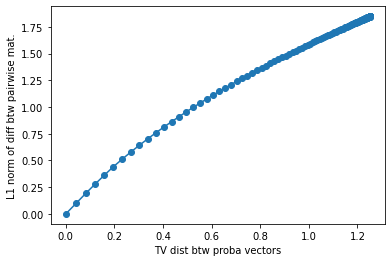

In [17]:
torch.manual_seed(0)
logits1 = torch.sort(torch.randn(4), descending=True)[0].numpy()
w1 = np.exp(logits1)
p1 = proba_plackett_luce(w1, all_ranks)
p_torch1 = torch.from_numpy(p1)
P1 = pairwise_matrix(p_torch1, torch_all_ranks, n=4)
print(f"{p_torch1} \n{P1}")

ms = np.linspace(1,50,1001)
dist_proba = list()
dist_pairwise = list()
for m in ms:
    #logits2 = torch.sort(torch.randn(4), descending=True)[0].numpy()
    w2 = np.exp(logits1)**m
    p2 = proba_plackett_luce(w2, all_ranks)
    p_torch2 = torch.from_numpy(p2)
    P2 = pairwise_matrix(p_torch2, torch_all_ranks, n=4)
    #print(f"for m = {m}\n{p_torch2} \n{P2}")
    
    dist_proba.append(torch.norm(p_torch1-p_torch2, 1))
    dist_pairwise.append(torch.norm(P1-P2,1))

#plt.plot(ms, dist_proba, "o-")
plt.plot(dist_proba, dist_pairwise, "o-")
plt.xlabel(f"TV dist btw proba vectors")
plt.ylabel(f"L1 norm of diff btw pairwise mat.")
plt.show()

# Performance vs Robustness profile

In [76]:
import os

def get_automatic_thresholds(w):
    p = proba_plackett_luce(w, all_ranks)
    p_torch = torch.from_numpy(p)
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    print(f"Pairwise mat: \n {P}")

    m = torch.flatten(torch.triu(P, 1))
    m = torch.sort(m[m != 0.0])[0]
    #m = torch.cat((torch.tensor([0.5]), m), dim=-1)
    #l = [ ((m[i+1] + m[i])/2).numpy() - 0.5 for i in range(0, m.shape[0]-1)]
    #thresholds_ = np.unique(l)
    minval = (m - 0.5)[0]
    maxval = (m - 0.5)[-1]
    thresholds_ = [0]
    for val in list(np.linspace(minval-0.0005, maxval+0.0005, 21)):
        thresholds_.append(val)
    print(f"thresholds = {thresholds_}")
    return thresholds_

def torch_dist(dist, P1, P2, torch_all_ranks, threshold, dist_type_sym):
        if dist == "erm":
            R1 = erm(P1, torch_all_ranks, n=4)
            R2 = erm(P2, torch_all_ranks, n=4)
        elif dist == "maxpair":
            R1 = maxpair(P1, torch_all_ranks, n=4, threshold=threshold)
            R2 = maxpair(P2, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            R1 = merge(P1, torch_all_ranks, threshold=threshold, n=4)
            R2 = merge(P2, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            R1 = depth(P1, torch_all_ranks, norm="l1", printer=False)
            R2 = depth(P2, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            R1 = wasserstein(P1, torch_all_ranks, n=4)
            R2 = wasserstein(P2, torch_all_ranks, n=4)
        if dist_type_sym:
            return symmetrized_hausdorff_on_kendall(R1, R2)
        else:
            return disymmetrized_hausdorff_on_kendall(R1, R2)

def launch_exp(dist, p_torch, w, delta, thresholds_, epochs, save=True, dist_type_sym=True, norm_type="1", ratio_norm_=1.0, nb_simu_training=25):
    #p = proba_plackett_luce(w, all_ranks)
    #p_torch = torch.from_numpy(p)
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    print(f"Original proba p ={p_torch} and pairwise = {pairwise_matrix(p_torch, torch_all_ranks)}")

    eps_list1 = []
    eps_list2 = []
    alt_eps_list1 = []
    alt_eps_list2 = []
    perf_list = []
    if dist in ["erm", "depth", "wasserstein"]:
        thresholds = [0.0]
    elif dist in ["maxpair", "merge"]:
        thresholds = thresholds_
        
    dict_training = dict()
    
    for i_, threshold in enumerate(thresholds):
        if threshold >= 0.4:
            div_ = 10
        else:
            div_ = 1
        print(f"\n \t EXP THRESHOLD nb {i_} = {threshold} \n \n \n")
        dist_Tp_Tq = lambda _P,_Q: torch_dist(dist, _P, _Q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
        
        #losses, qs_, epsilons, etas, alphas, s_, mean_qs, mean_epsilons, mean_etas, mean_alphas = approximate_breakdown_function(delta-1e-6, dist_Tp_Tq, p_torch, epochs=epochs, std_dev=0.001, lr=0.01/div_, maxiter=21, eval_strat="smoothed")
        #losses, qs_, lambdas, s_, mean_qs, mean_lambdas 
        
        norms, losses, s_, qs_, mean_qs, phis, mean_phi2, lambdas, mean_lambdas, grad_data, freq_phi = approximate_breakdown_function(delta-1e-6, dist_Tp_Tq, P, epochs=epochs, std_dev=0.001, lr=0.5/div_, maxiter=21, eval_strat="smoothed", norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)
        plot_end_training(P, dist_Tp_Tq, norms, losses, mean_qs, phis, mean_phi2, lambdas, mean_lambdas, grad_data, freq_phi, norm_type)
        dict_res_training = {"norms":norms, "losses":losses, "s_":s_, "qs_":qs_, "mean_qs":mean_qs, "phis":phis, "mean_phi2":mean_phi2, "lambdas":lambdas, "mean_lambdas":mean_lambdas, "grad_data":grad_data, "freq_phi":freq_phi}
        dict_training[threshold] = dict_res_training
        
        # q1 is the mean of the last q found
        qlist_ = qs_[epochs-2000:]
        q1 = np.mean(qlist_, axis=0)
        
        # q2 is the overall mean
        q2 = mean_qs[-1]
        print(f"\n Found attack distrib q = {q2} (erm = {erm(torch.tensor(q2), torch_all_ranks)}) OR \nq = {q1} (erm = {erm(torch.tensor(q1), torch_all_ranks)})")# and corresponding phi = {erm(q2, torch_all_ranks)} \n")
        
        # eps from q2
        #if (erm(torch.tensor(q2), torch_all_ranks) == erm(P, torch_all_ranks)).all():
        #    eps_list1.append(torch.inf)
        #    eps_list2.append(torch.inf)
        #else:
        eps_list1.append(torch.norm(P - torch.tensor(q2), 1))
        eps_list2.append(torch.norm(P - torch.tensor(q2), 2))
        
        # esp from q1
        #if (erm(torch.tensor(q1), torch_all_ranks) == erm(P, torch_all_ranks)).all():
        #    alt_eps_list1.append(torch.inf)
        #    alt_eps_list2.append(torch.inf)
        #else:
        alt_eps_list1.append(torch.norm(P - torch.tensor(q1).unsqueeze(0), 1))
        alt_eps_list2.append(torch.norm(P - torch.tensor(q1).unsqueeze(0), 2))
        
        if dist == "erm":
            Ptilde = erm(P, torch_all_ranks, n=4)
        elif dist == "maxpair":
            Ptilde = maxpair(P, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            Ptilde = merge(P, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            Ptilde = depth(P, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            Ptilde = wasserstein(P, torch_all_ranks, n=4)
        exp_kendall = expected_kendall(Ptilde, P).detach().item()
        perf_list.append(exp_kendall)
        
    if save:
        directory = f"{os.getcwd()}/perf_robustness_profile/pairwise_res/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}_ratio_{ratio_norm_}.pt"
        #training_dict = {"losses": losses, "qs_":qs_, "epsilons": epsilons, "etas":etas, "alphas":alphas, "s_":s_, "mean_qs":mean_qs, "mean_epsilons":mean_epsilons, "mean_etas":mean_etas, "mean_alphas":mean_alphas}
        #final_val_dict = {"perf_list":perf_list, "eps_list1": eps_list1, "eps_list2":eps_list2}
        #training_dict = {"losses": losses, "qs_":qs_, "lambdas":lambdas, "s_":s_, "mean_qs":mean_qs, "mean_lambas":mean_lambdas}
        final_val_dict = {"thresholds":thresholds, "perf_list":perf_list, "eps_list1": eps_list1, "eps_list2":eps_list2, "alt_eps_list1":alt_eps_list1, "alt_eps_list2":alt_eps_list1, "p_torch":p_torch}
        
        torch.save({"training_dict": dict_training, "final_val_dict":final_val_dict}, directory+filename)
    
    #if len(thresholds) == 1:
    #    return perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, dict_res_training
    #else:
    #    if save:
    #        directory = f"{os.getcwd()}/perf_robustness_profile/"
    #        if not os.path.exists(directory):
    #            os.makedirs(directory)
    #        torch.save({"training_dict": dict_training, "final_val_dict":dict_final}, directory+filename)
    return perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, dict_training
                


# Launch New Experiments

#### Experiment plan

- Unimodal
    1) Plackett-Luce with m = 0.01, 0.1, 0.25, 0.5, 1, 5, 10
        ERM (m=0.1, 0.5, 1, 5 --> done)
        Maxpair
        Merge
        Depth
        Wasserstein
    2) Plackett-Luce with two items almost tied to untied.

- Multimodal
    1) Still SST --> to define
    2) Not SST

In [19]:
def check_SST(P):
    P = P.numpy()
    cycles = list()
    P2 = np.nan_to_num((P-1/2).clip(0))
    P2
    G = nx.from_numpy_matrix(P2, create_using=nx.MultiDiGraph())
    for cycle in nx.simple_cycles(G):
        cycles.append(cycle)
    if len(cycles) < 1:
        print("The distribution is SST")
        res = True
    else:
        print("The distribution is -NOT- SST")
        res = False
    return res

def get_multimodal(ws, ratios, all_ranks):
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    p_torch = torch.zeros((1,24))
    print(p_torch, p_torch.shape)
    for (w, ratio) in zip(ws, ratios):
        p_ = proba_plackett_luce(w, all_ranks)
        p_torch_ = torch.from_numpy(p_)
        print(p_torch_, p_torch_.shape)
        p_torch += ratio*p_torch_
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    is_sst = check_SST(P)
    
    return p_torch, P

p_torch, P = get_multimodal(ws=[w1,w2], ratios=[0.5,0.5], all_ranks=all_ranks)
P = pairwise_matrix(p_torch, torch_all_ranks, n=4)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) torch.Size([1, 24])
tensor([[0.3739, 0.0568, 0.1709, 0.0110, 0.0194, 0.0082, 0.1775, 0.0269, 0.0319,
         0.0008, 0.0043, 0.0007, 0.0685, 0.0044, 0.0269, 0.0007, 0.0013, 0.0005,
         0.0071, 0.0030, 0.0033, 0.0005, 0.0012, 0.0004]], dtype=torch.float64) torch.Size([1, 24])
tensor([[nan, 0., nan, 0., 0., 0., nan, 0., nan, 0., 0., 0., nan, 0., nan, 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64) torch.Size([1, 24])
The distribution is SST


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_25506/2434315176.py:12: RuntimeWarning: invalid value encountered in true_divide
  val_.append(num_/denom_)


w1=[20.134888    1.6853822   0.98549694  0.07977074]
w2=[1.5631527e+00 3.6629871e-01 1.0582153e+00 2.5029836e-04]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) torch.Size([1, 24])
tensor([[4.9871e-01, 4.0368e-02, 3.0097e-01, 1.4245e-02, 1.6101e-02, 9.4145e-03,
         6.4706e-02, 5.2376e-03, 3.4099e-03, 1.3509e-05, 2.6417e-04, 1.2930e-05,
         3.7802e-02, 1.7892e-03, 3.3009e-03, 1.3078e-05, 1.4474e-04, 1.2115e-05,
         1.9419e-03, 1.1355e-03, 2.4557e-04, 1.2020e-05, 1.3899e-04, 1.1634e-05]],
       dtype=torch.float64) torch.Size([1, 24])
tensor([[1.3447e-01, 3.1806e-05, 3.8830e-01, 2.6533e-04, 2.3633e-05, 6.8274e-05,
         7.3080e-02, 1.7285e-05, 4.9477e-02, 7.9224e-06, 6.9796e-06, 4.7250e-06,
         2.8669e-01, 1.9590e-04, 6.7217e-02, 1.0763e-05, 3.7217e-05, 8.7212e-06,
         1.1270e-05, 3.2559e-05, 6.1244e-06, 4.1461e-06, 2.4038e-05, 5.6329e-06]],
       dtype=torch.float64) torch.Size([1, 24])
The distrib

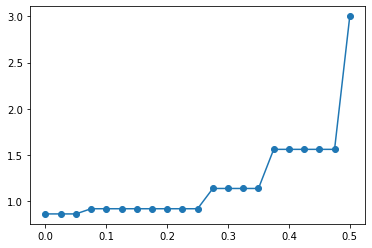

In [73]:
# Select a nice seed
torch.manual_seed(453) #938 (unimodal), 453 (multimodal sst)

#m = 5
#logits = torch.sort(torch.randn(4), descending=True)[0].numpy()
#w = np.exp(logits)**m
#print(w)
#p = proba_plackett_luce(w, all_ranks)
#p_torch = torch.from_numpy(p)
#P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
#print(p_torch)
#print(P)

# For multimodal SST
m1 = 1
logits1 = torch.sort(torch.randn(4), descending=True)[0].numpy()
w1 = np.exp(logits1)**m # 1 > 2 > 3
m2 = 1
logits2 = torch.randn(4).numpy()
w2 = np.exp(logits2)**m
print(f"w1={w1}\nw2={w2}")
p_torch, P = get_multimodal(ws=[w1,w2], ratios=[0.5,0.5], all_ranks=all_ranks)
print(f"{p_torch}\n{P}")

#m3 = 1
#w3 = np.array([np.exp(n_items-2)**m3, np.exp(n_items-0)**m3, np.exp(n_items-1)**m3, np.exp(n_items-3)**m3]) # 2 > 3 > 1
#m4 = 100
#w4 = np.array([np.exp(n_items-2)**m4, np.exp(n_items-0)**m4, np.exp(n_items-1)**m4, np.exp(n_items-3)**m4]) #

#p_torch, P = get_multimodal(ws=[w1,w2,w3], ratios=[0.3,0.3,0.3], all_ranks=all_ranks)
#w = f"multimodal_m1={m1}_m2={m2}_m3={m3}"


vals = list()
thresholds = np.linspace(0,0.5,21)
for i, threshold in enumerate(thresholds):
    Ptilde = maxpair(P, torch_all_ranks, n=4, threshold=threshold)
    #print(f"i = {i} \n{Ptilde} \n")
    val = expected_kendall(Ptilde, P).detach().item()
    vals.append(val)

plt.plot(thresholds, vals, "o-")
plt.show()

In [ ]:
# Generate a distribution
    # Done 0.01 / 0.1 / 0.25 / 0.5 / 1.0

torch.manual_seed(453)

#m = 5
#logits = torch.sort(torch.randn(4), descending=True)[0].numpy()
#w = np.exp(logits)**m
#print(w)
#p = proba_plackett_luce(w, all_ranks)
#p_torch = torch.from_numpy(p)
#P = pairwise_matrix(p_torch, torch_all_ranks, n=4)

# Multimodal SST
m1 = 1
logits1 = torch.sort(torch.randn(4), descending=True)[0].numpy()
w1 = np.exp(logits1)**m # 1 > 2 > 3
m2 = 1
logits2 = torch.randn(4).numpy()
w2 = np.exp(logits2)**m
print(f"w1={w1}\nw2={w2}")
p_torch, P = get_multimodal(ws=[w1,w2], ratios=[0.5,0.5], all_ranks=all_ranks)
print(f"{p_torch}\n{P}")
w = f"multimodal_sst_m1={m1}_m2={m2}"

print(f"proba = {p_torch} \n{P}")

# Other parameters
delta = 1
epochs = 20000
thresholds_ = np.linspace(0., 0.5, 21) #get_automatic_thresholds(w)
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
nb_simu_training = 25

In [92]:
a = np.array(["test"])
b = np.array(["b","b","b"])
c = np.array(["b","b","b"])
np.max((a.shape[0],b.shape[0],c.shape[0]))

3

### ERM

Original proba p =tensor([[3.1659e-01, 2.0200e-02, 3.4464e-01, 7.2553e-03, 8.0621e-03, 4.7414e-03,
         6.8893e-02, 2.6274e-03, 2.6443e-02, 1.0716e-05, 1.3558e-04, 8.8275e-06,
         1.6225e-01, 9.9255e-04, 3.5259e-02, 1.1920e-05, 9.0977e-05, 1.0418e-05,
         9.7659e-04, 5.8403e-04, 1.2585e-04, 8.0828e-06, 8.1514e-05, 8.6335e-06]]) and pairwise = tensor([[0.0000, 0.8665, 0.7748, 0.9979],
        [0.1335, 0.0000, 0.4441, 0.9771],
        [0.2252, 0.5559, 0.0000, 0.9624],
        [0.0021, 0.0229, 0.0376, 0.0000]])

 	 EXP THRESHOLD nb 0 = 0.0 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.7315, 0.7177, 0.6651],
        [0.2685, 0.0000, 0.7425, 0.7465],
        [0.2823, 0.3349, 0.0000, 0.7446],
        [0.2575, 0.2535, 0.2554, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([0.8621, 0.7710, 0.4930, 0.9419, 0.9722, 0.9576], requires_grad=True) 
 	 grad = tensor([-0., -0., -1.,  1., -0., -0.]) 
 	 lr = 0.4999525 
 	 phi = 1.72 and std_dev = 0.1 and norm diff = 1.1077326536178589 
 

EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.8685, 0.7662, 0.5282],
        [0.1315, 0.0000, 0.6319, 0.9766],
        [0.2338, 0.4718, 0.0000, 0.9625],
        [0.3681, 0.0234, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.8019,  1.1383,  0.0599,  0.3585, 20.3478, 12.3264],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2., -2.]) 
 	 lr = 0.36695250000000335 
 	 phi = 1.32 and std_dev = 0.0018894849871330585 and norm diff = 1.377934455871582 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.3200]) 
 	 lr = 0.36695250000000335
EPOCH 3000: 
 	 Q2=tensor([[0.0000, 0.8444, 0.8185, 0.5130],
        [0.1556, 0.0000, 0.5689, 0.9775],
        [0.1815, 0.4870, 0.0000, 0.9618],
        [0.4311, 0.0225, 0.0382, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.2140,  1.7547,  0.0267,  0.1600, 21.1880, 12.1020],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2., -2.]) 
 	 lr = 0.3574525000000038 
 	 phi = 1.44 and std_de

EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.8588, 0.8026, 0.7019],
        [0.1412, 0.0000, 0.6049, 0.9773],
        [0.1974, 0.2981, 0.0000, 0.9620],
        [0.3951, 0.0227, 0.0380, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.5417,  1.5326,  0.6773,  0.2655, 20.9813, 12.1693],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.]) 
 	 lr = 0.2339525000000092 
 	 phi = 1.0 and std_dev = 0.001336186912484746 and norm diff = 1.1502972841262817 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-1.0133e-06]) 
 	 lr = 0.2339525000000092
EPOCH 5800: 
 	 Q2=tensor([[0.0000, 0.8643, 0.7587, 0.5958],
        [0.1357, 0.0000, 0.8531, 0.9774],
        [0.2413, 0.4042, 0.0000, 0.9634],
        [0.1469, 0.0226, 0.0366, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6851,  1.0719,  0.2369,  2.4029, 21.0791, 12.6656],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.22445250000000874 
 	 phi = 1.0 and std_d

EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.8682, 0.7719, 0.4887],
        [0.1318, 0.0000, 0.5111, 0.9772],
        [0.2281, 0.5113, 0.0000, 0.9630],
        [0.4889, 0.0228, 0.0370, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7936,  1.1920, -0.0231,  0.0226, 20.8836, 12.5121],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.10095249999999892 
 	 phi = 1.36 and std_dev = 0.0010910245111774533 and norm diff = 1.1473090648651123 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.3600]) 
 	 lr = 0.10095249999999892
EPOCH 8600: 
 	 Q2=tensor([[0.0000, 0.8652, 0.7573, 0.4769],
        [0.1348, 0.0000, 0.5036, 0.9770],
        [0.2427, 0.5231, 0.0000, 0.9625],
        [0.4964, 0.0230, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7087e+00,  1.0602e+00, -4.8520e-02,  7.2236e-03,  2.0762e+01,
         1.2344e+01], requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0., -2.,  2.]) 
 	 lr = 0.0914524999999989

EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.8662, 0.7709, 0.4861],
        [0.1338, 0.0000, 0.5072, 0.9770],
        [0.2291, 0.5139, 0.0000, 0.9623],
        [0.4928, 0.0230, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7375e+00,  1.1825e+00, -2.8507e-02,  1.4643e-02,  2.0782e+01,
         1.2271e+01], requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0., -2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.4 and std_dev = 0.0009448690018127142 and norm diff = 1.1130709648132324 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.4000]) 
 	 lr = 0.024999999999999745
EPOCH 11400: 
 	 Q2=tensor([[0.0000, 0.8651, 0.7749, 0.4847],
        [0.1349, 0.0000, 0.5078, 0.9771],
        [0.2251, 0.5153, 0.0000, 0.9625],
        [0.4922, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7052e+00,  1.2216e+00, -3.1550e-02,  1.5780e-02,  2.0845e+01,
         1.2337e+01], requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.])

EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.8658, 0.7780, 0.4882],
        [0.1342, 0.0000, 0.5137, 0.9770],
        [0.2220, 0.5118, 0.0000, 0.9623],
        [0.4863, 0.0230, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7265,  1.2520, -0.0242,  0.0282, 20.7863, 12.2644],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.36 and std_dev = 0.0008451240722648988 and norm diff = 1.1126186847686768 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.3600]) 
 	 lr = 0.024999999999999745
EPOCH 14200: 
 	 Q2=tensor([[0.0000, 0.8679, 0.7721, 0.4888],
        [0.1321, 0.0000, 0.5130, 0.9771],
        [0.2279, 0.5112, 0.0000, 0.9624],
        [0.4870, 0.0229, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7862,  1.1943, -0.0229,  0.0267, 20.8421, 12.3027],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.04 and

EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.8655, 0.7741, 0.4853],
        [0.1345, 0.0000, 0.5083, 0.9771],
        [0.2259, 0.5147, 0.0000, 0.9625],
        [0.4917, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7165e+00,  1.2133e+00, -3.0284e-02,  1.6973e-02,  2.0838e+01,
         1.2333e+01], requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.44 and std_dev = 0.0007714937890274594 and norm diff = 1.1168835163116455 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.4400]) 
 	 lr = 0.024999999999999745
EPOCH 17000: 
 	 Q2=tensor([[0.0000, 0.8676, 0.7774, 0.4861],
        [0.1324, 0.0000, 0.5079, 0.9771],
        [0.2226, 0.5139, 0.0000, 0.9625],
        [0.4921, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7763e+00,  1.2464e+00, -2.8647e-02,  1.6056e-02,  2.0795e+01,
         1.2316e+01], requires_grad=True) 
 	 grad = tensor([2., 2., -0., -0., 2., 2.]) 
 

EPOCH 19600: 
 	 Q2=tensor([[0.0000, 0.8683, 0.7772, 0.4882],
        [0.1317, 0.0000, 0.5051, 0.9771],
        [0.2228, 0.5118, 0.0000, 0.9625],
        [0.4949, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7973e+00,  1.2443e+00, -2.4229e-02,  1.0244e-02,  2.0825e+01,
         1.2321e+01], requires_grad=True) 
 	 grad = tensor([2., 2., -0., -0., 2., 2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.36 and std_dev = 0.0007142674934085948 and norm diff = 1.1123621463775635 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.3600]) 
 	 lr = 0.024999999999999745
EPOCH 19800: 
 	 Q2=tensor([[0.0000, 0.8666, 0.7718, 0.4873],
        [0.1334, 0.0000, 0.5061, 0.9770],
        [0.2282, 0.5127, 0.0000, 0.9624],
        [0.4939, 0.0230, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7482e+00,  1.1911e+00, -2.6060e-02,  1.2419e-02,  2.0785e+01,
         1.2309e+01], requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0., -2., -2.]) 
 

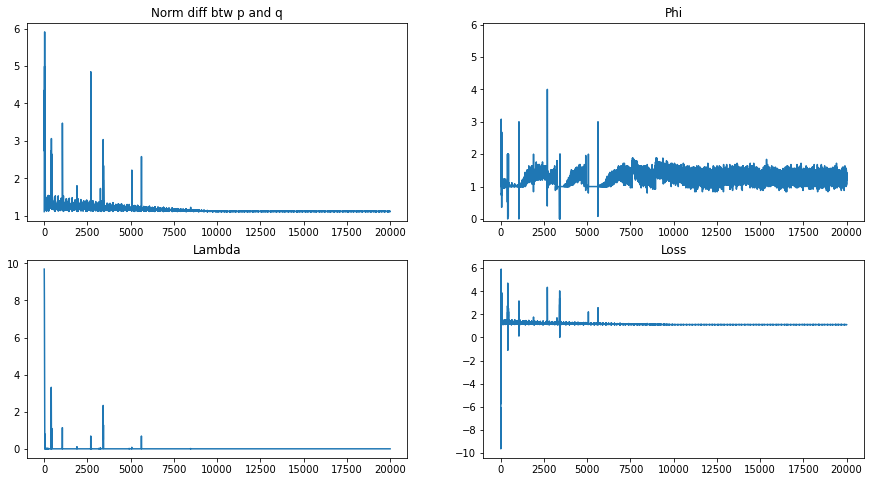


 

Phi freq: {0: 10, 1: 2784, 2: 49, 3: 6, 4: 1, 5: 0, 6: 0}

 Found attack distrib q = [[0.         0.8651509  0.7700782  0.5297159 ]
 [0.13484462 0.         0.5808366  0.97635853]
 [0.22992063 0.47028533 0.         0.96220917]
 [0.41915742 0.02363739 0.03778978 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])) OR 
q = [[0.         0.8670673  0.77087384 0.4886483 ]
 [0.13292287 0.         0.50813013 0.97705126]
 [0.22912651 0.51135176 0.         0.96239614]
 [0.49186942 0.02294284 0.0376154  0.        ]] (erm = tensor([[0., 1., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 0., 0., 0.]]))


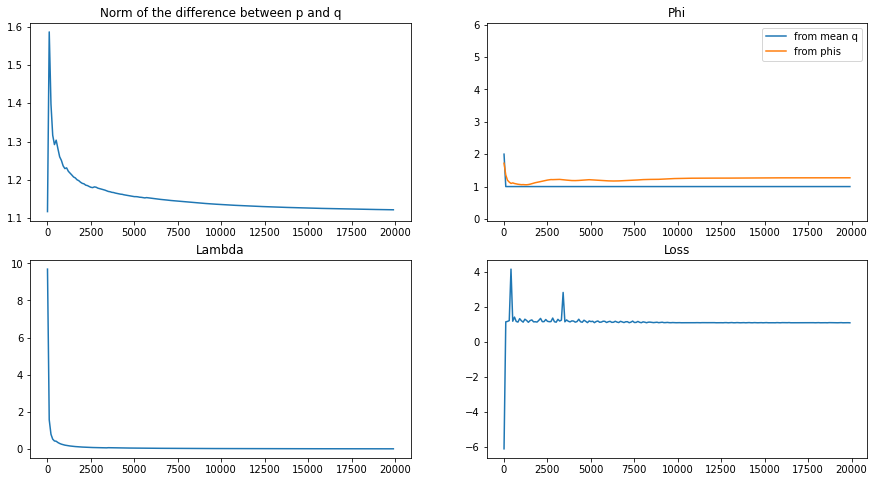

In [78]:
# ERM
dist = "erm"
save = True
perf_list_erm, eps_list_erm1, eps_list_erm2, alt_eps_list_erm1, alt_eps_list_erm2, dict_res_training_erm = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training, save=save)



perf_list = [0.30369800329208374] 

 and eps_list1 (l1 norm) = [tensor(5.7417)]  
 and eps_list2 (l2 norm) = [tensor(1.7663)] 

 and alt eps list1 (l1 norm) = [tensor(7.1971)] 
 and alt eps list2 (l2 norm) = [tensor(2.4654)]


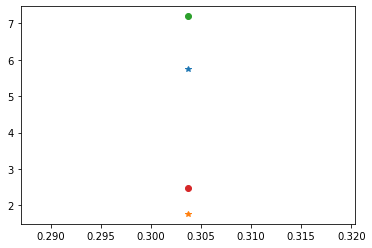

In [59]:
print(f"perf_list = {perf_list_erm} \n\n and eps_list1 (l1 norm) = {eps_list_erm1}  \n and eps_list2 (l2 norm) = {eps_list_erm2} \n\n and alt eps list1 (l1 norm) = {alt_eps_list_erm1} \n and alt eps list2 (l2 norm) = {alt_eps_list_erm2}")

plt.plot(perf_list_erm, eps_list_erm1, '*')
plt.plot(perf_list_erm, eps_list_erm2, '*')
plt.plot(perf_list_erm, alt_eps_list_erm1, 'o')
plt.plot(perf_list_erm, alt_eps_list_erm2, 'o')
plt.show()

### Maxpair

Original proba p =tensor([[3.1659e-01, 2.0200e-02, 3.4464e-01, 7.2553e-03, 8.0621e-03, 4.7414e-03,
         6.8893e-02, 2.6274e-03, 2.6443e-02, 1.0716e-05, 1.3558e-04, 8.8275e-06,
         1.6225e-01, 9.9255e-04, 3.5259e-02, 1.1920e-05, 9.0977e-05, 1.0418e-05,
         9.7659e-04, 5.8403e-04, 1.2585e-04, 8.0828e-06, 8.1514e-05, 8.6335e-06]]) and pairwise = tensor([[0.0000, 0.8665, 0.7748, 0.9979],
        [0.1335, 0.0000, 0.4441, 0.9771],
        [0.2252, 0.5559, 0.0000, 0.9624],
        [0.0021, 0.0229, 0.0376, 0.0000]])

 	 EXP THRESHOLD nb 0 = 0.0 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.3254, 0.1832, 0.1994],
        [0.6746, 0.0000, 0.1635, 0.8882],
        [0.8168, 0.8006, 0.0000, 0.1967],
        [0.8365, 0.1118, 0.8033, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-0.5367, -1.7290, -1.5070, -2.0581,  3.4722, -1.5424],
       requires_grad=True) 
 	 grad = tensor([-2.7977, -5.0000, -5.0000, -5.0000,  5.0000, -5.0000]) 
 	 lr = 0.4999525 
 	 phi = 1.84 and std_dev = 0.1 

EPOCH 2600: 
 	 Q2=tensor([[0.0000, 0.8659, 0.7908, 0.5000],
        [0.1341, 0.0000, 0.5000, 0.9766],
        [0.2092, 0.5000, 0.0000, 0.9618],
        [0.5000, 0.0234, 0.0382, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7273e+00, 1.3905e+00, 1.6046e-06, 7.6399e-06, 2.0378e+01, 1.2105e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2.,  2.]) 
 	 lr = 0.3764525000000032 
 	 phi = 2.24 and std_dev = 0.00196078431372549 and norm diff = 1.2886114120483398 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-1.2400]) 
 	 lr = 0.3764525000000032
EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.8400, 0.6844, 0.5000],
        [0.1600, 0.0000, 0.5000, 0.9775],
        [0.3156, 0.5000, 0.0000, 0.9616],
        [0.5000, 0.0225, 0.0384, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.1244e+00, 5.8429e-01, 7.0096e-07, 3.3375e-06, 2.1239e+01, 1.2026e+01],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.366952500

EPOCH 5400: 
 	 Q2=tensor([[0.0000, 0.8585, 0.7461, 0.5000],
        [0.1415, 0.0000, 0.5000, 0.9773],
        [0.2539, 0.5000, 0.0000, 0.9620],
        [0.5000, 0.0227, 0.0380, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.5339e+00, 9.6964e-01, 1.0190e-10, 4.8517e-10, 2.1005e+01, 1.2156e+01],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.24345250000000956 
 	 phi = 1.52 and std_dev = 0.0013607016498184135 and norm diff = 1.1639792919158936 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.5200]) 
 	 lr = 0.24345250000000956
EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.8783, 0.7827, 0.5000],
        [0.1217, 0.0000, 0.5000, 0.9769],
        [0.2173, 0.5000, 0.0000, 0.9618],
        [0.5000, 0.0231, 0.0382, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([3.1073e+00, 1.3014e+00, 5.9896e-11, 2.8519e-10, 2.0683e+01, 1.2100e+01],
       requires_grad=True) 
 	 grad = tensor([ 2.,  2., -0., -0., -2., -2.]) 
 	 lr = 0.23395

EPOCH 8200: 
 	 Q2=tensor([[0.0000, 0.8596, 0.7832, 0.5000],
        [0.1404, 0.0000, 0.5000, 0.9769],
        [0.2168, 0.5000, 0.0000, 0.9628],
        [0.5000, 0.0231, 0.0372, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.5607e+00, 1.3067e+00, 4.1111e-13, 1.9574e-12, 2.0677e+01, 1.2436e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2.,  2.]) 
 	 lr = 0.11045249999999864 
 	 phi = 1.92 and std_dev = 0.0011042479306102601 and norm diff = 1.1340138912200928 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.9200]) 
 	 lr = 0.11045249999999864
EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.8690, 0.7581, 0.5000],
        [0.1310, 0.0000, 0.5000, 0.9772],
        [0.2419, 0.5000, 0.0000, 0.9626],
        [0.5000, 0.0228, 0.0374, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.8177e+00, 1.0673e+00, 3.2498e-13, 1.5473e-12, 2.0917e+01, 1.2356e+01],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.10095

EPOCH 11000: 
 	 Q2=tensor([[0.0000, 0.8678, 0.7718, 0.5000],
        [0.1322, 0.0000, 0.5000, 0.9770],
        [0.2282, 0.5000, 0.0000, 0.9623],
        [0.5000, 0.0230, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7810e+00, 1.1908e+00, 8.0303e-14, 3.8235e-13, 2.0761e+01, 1.2274e+01],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0., -2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.8 and std_dev = 0.0009534192529917125 and norm diff = 1.1116318702697754 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.8000]) 
 	 lr = 0.024999999999999745
EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.8663, 0.7752, 0.5000],
        [0.1337, 0.0000, 0.5000, 0.9771],
        [0.2248, 0.5000, 0.0000, 0.9626],
        [0.5000, 0.0229, 0.0374, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7399e+00, 1.2242e+00, 7.5963e-14, 3.6168e-13, 2.0818e+01, 1.2357e+01],
       requires_grad=True) 
 	 grad = tensor([2., 2., -0., -0., 2., 2.]) 
 	 lr = 0.024999

EPOCH 13800: 
 	 Q2=tensor([[0.0000, 0.8670, 0.7759, 0.5000],
        [0.1330, 0.0000, 0.5000, 0.9771],
        [0.2241, 0.5000, 0.0000, 0.9623],
        [0.5000, 0.0229, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7582e+00, 1.2316e+00, 3.6889e-14, 1.7564e-13, 2.0798e+01, 1.2256e+01],
       requires_grad=True) 
 	 grad = tensor([ 2.,  2., -0., -0.,  2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.96 and std_dev = 0.0008512256898069512 and norm diff = 1.1170367002487183 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.9600]) 
 	 lr = 0.024999999999999745
EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.8658, 0.7801, 0.5000],
        [0.1342, 0.0000, 0.5000, 0.9770],
        [0.2199, 0.5000, 0.0000, 0.9625],
        [0.5000, 0.0230, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7270e+00, 1.2741e+00, 3.4895e-14, 1.6615e-13, 2.0764e+01, 1.2339e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2.,  2.]) 
 	 lr = 0.0

EPOCH 16600: 
 	 Q2=tensor([[0.0000, 0.8665, 0.7710, 0.5011],
        [0.1335, 0.0000, 0.5006, 0.9771],
        [0.2290, 0.4989, 0.0000, 0.9625],
        [0.4994, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7453e+00, 1.1839e+00, 2.1378e-03, 1.2792e-03, 2.0842e+01, 1.2336e+01],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2.,  2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.8 and std_dev = 0.0007761271487346334 and norm diff = 1.1129722595214844 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.8000]) 
 	 lr = 0.024999999999999745
EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.8650, 0.7745, 0.5010],
        [0.1350, 0.0000, 0.5006, 0.9771],
        [0.2255, 0.4990, 0.0000, 0.9625],
        [0.4994, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7041e+00, 1.2173e+00, 2.0223e-03, 1.2101e-03, 2.0799e+01, 1.2319e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.]) 
 	 lr = 0.02

EPOCH 19400: 
 	 Q2=tensor([[0.0000, 0.8657, 0.7752, 0.5005],
        [0.1343, 0.0000, 0.5003, 0.9771],
        [0.2248, 0.4995, 0.0000, 0.9625],
        [0.4997, 0.0229, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7225e+00, 1.2247e+00, 9.8203e-04, 5.8764e-04, 2.0834e+01, 1.2317e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 2.04 and std_dev = 0.0007179396552568181 and norm diff = 1.1181522607803345 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-1.0400]) 
 	 lr = 0.024999999999999745
EPOCH 19600: 
 	 Q2=tensor([[0.0000, 0.8678, 0.7694, 0.5005],
        [0.1322, 0.0000, 0.5003, 0.9771],
        [0.2306, 0.4995, 0.0000, 0.9624],
        [0.4997, 0.0229, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7822e+00, 1.1680e+00, 9.2895e-04, 5.5588e-04, 2.0844e+01, 1.2310e+01],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.0

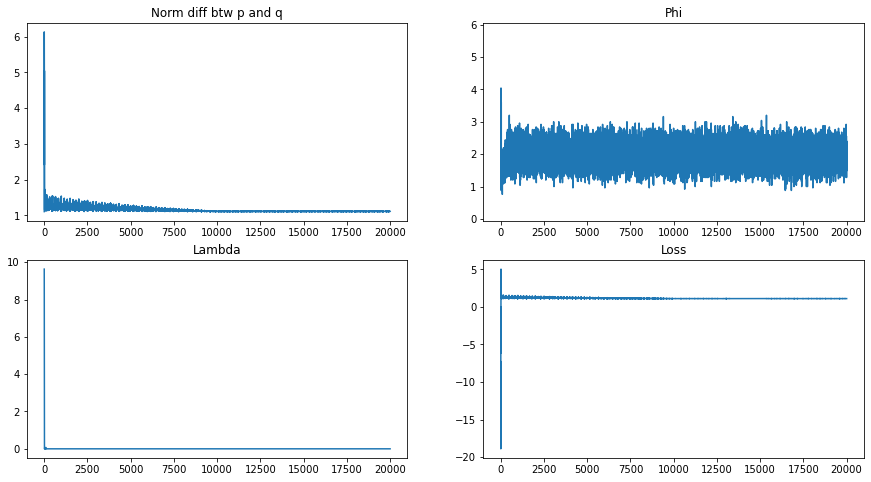


 

Phi freq: {0: 0, 1: 8, 2: 1044, 3: 9, 4: 0, 5: 0, 6: 0}

 Found attack distrib q = [[0.         0.8653901  0.77110595 0.50173724]
 [0.13460846 0.         0.5047382  0.976866  ]
 [0.22889301 0.4982574  0.         0.9621022 ]
 [0.4952583  0.02313604 0.03789402 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])) OR 
q = [[0.         0.8668557  0.7725522  0.5004236 ]
 [0.13312867 0.         0.5002449  0.9770748 ]
 [0.22744913 0.49957642 0.         0.9624936 ]
 [0.49975508 0.02291737 0.03752593 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]))

 	 EXP THRESHOLD nb 1 = 0.025 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.8166, 0.1832, 0.8887],
        [0.1834, 0.0000, 0.8732, 0.1978],
        [0.8168, 0.1113, 0.0000, 0.2754],
        [0.1268, 0.8022, 0.7246, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.7259, -1.7290,  3.4930,  2.9419,

EPOCH 2600: 
 	 Q2=tensor([[0.0000, 0.9127, 0.9856, 0.9787],
        [0.0873, 0.0000, 0.0427, 0.0191],
        [0.0144, 0.0213, 0.0000, 0.9822],
        [0.9573, 0.9809, 0.0178, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([  4.7275,  33.8265,  22.5011, -10.7076, -25.2235,  27.1276],
       requires_grad=True) 
 	 grad = tensor([-5.,  5., -5., -5., -5., -5.]) 
 	 lr = 0.3764525000000032 
 	 phi = 1.0 and std_dev = 0.00196078431372549 and norm diff = 4.403570652008057 
 
 	 lambda_=tensor([110.6277], requires_grad=True) and grad = tensor([-1.0133e-06]) 
 	 lr = 0.3764525000000032
EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.8632, 0.9200, 0.4359],
        [0.1368, 0.0000, 0.9753, 0.8417],
        [0.0800, 0.5641, 0.0000, 0.9758],
        [0.0247, 0.1583, 0.0242, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6559,  5.2486, -0.1471, 19.2409,  2.1579, 19.6282],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5., -5.,  5., -5.]) 
 	 lr = 0.36695250000000335 
 	 phi = 4.0

EPOCH 5400: 
 	 Q2=tensor([[0.0000, 0.0103, 0.0386, 0.9068],
        [0.9897, 0.0000, 0.0715, 0.1311],
        [0.9614, 0.0932, 0.0000, 0.0803],
        [0.9285, 0.8689, 0.9197, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-47.6968, -11.9545,   4.3629,  -5.9953,  -2.8127,  -5.2244],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5.,  5.,  5.,  5.]) 
 	 lr = 0.24345250000000956 
 	 phi = 4.0 and std_dev = 0.0013607016498184135 and norm diff = 8.59864330291748 
 
 	 lambda_=tensor([133858.8906], requires_grad=True) and grad = tensor([-3.0000]) 
 	 lr = 0.24345250000000956
EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.0201, 0.9196, 0.9370],
        [0.9799, 0.0000, 0.0430, 0.9539],
        [0.0804, 0.0630, 0.0000, 0.1176],
        [0.9570, 0.0461, 0.8824, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-23.8962,   5.2226,   6.9326, -10.6295,   9.8454,  -3.2523],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5.,  5., -5.]) 
 	 lr = 0.2339525000000092 
 	 ph

EPOCH 8200: 
 	 Q2=tensor([[0.0000, 0.9711, 0.9223, 0.0213],
        [0.0289, 0.0000, 0.0464, 0.8987],
        [0.0777, 0.9787, 0.0000, 0.8772],
        [0.9536, 0.1013, 0.1228, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 16.3224,   5.4387, -22.4420,  -9.7846,   3.9352,   3.0732],
       requires_grad=True) 
 	 grad = tensor([ 5.,  5., -5.,  5., -5.,  5.]) 
 	 lr = 0.11045249999999864 
 	 phi = 3.0 and std_dev = 0.0011042479306102601 and norm diff = 3.593456268310547 
 
 	 lambda_=tensor([32678664.], requires_grad=True) and grad = tensor([-2.0000]) 
 	 lr = 0.11045249999999864
EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.9599, 0.8883, 0.0340],
        [0.0401, 0.0000, 0.0430, 0.9021],
        [0.1117, 0.9660, 0.0000, 0.8910],
        [0.9570, 0.0979, 0.1090, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 11.4752,   3.4744, -13.7239, -10.6199,   4.1061,   3.5856],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5., -5., -5.,  5.]) 
 	 lr = 0.10095249999999892 
 	 ph

EPOCH 11000: 
 	 Q2=tensor([[0.0000, 0.9538, 0.8496, 0.0641],
        [0.0462, 0.0000, 0.9527, 0.9703],
        [0.1504, 0.9359, 0.0000, 0.1431],
        [0.0473, 0.0297, 0.8569, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 9.8166,  2.3248, -6.8004,  9.5670, 15.8499, -2.4937],
       requires_grad=True) 
 	 grad = tensor([-5., -5.,  5., -5.,  5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 4.0 and std_dev = 0.0009534192529917125 and norm diff = 3.8664298057556152 
 
 	 lambda_=tensor([1.6705e+08], requires_grad=True) and grad = tensor([-3.0000]) 
 	 lr = 0.024999999999999745
EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.9569, 0.7297, 0.0999],
        [0.0431, 0.0000, 0.9234, 0.9698],
        [0.2703, 0.9001, 0.0000, 0.2924],
        [0.0766, 0.0302, 0.7076, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([10.5992,  0.8499, -4.0066,  5.5311, 15.5471, -0.7101],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5., -5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 4

EPOCH 13800: 
 	 Q2=tensor([[0.0000, 0.6455, 0.0696, 0.6034],
        [0.3545, 0.0000, 0.8155, 0.2947],
        [0.9304, 0.3966, 0.0000, 0.1137],
        [0.1845, 0.7053, 0.8863, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 0.4104, -6.1793,  0.2607,  1.7097, -0.6968, -3.3960],
       requires_grad=True) 
 	 grad = tensor([-5.,  5., -5., -5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 6.0 and std_dev = 0.0008512256898069512 and norm diff = 5.913171768188477 
 
 	 lambda_=tensor([3.6355e+08], requires_grad=True) and grad = tensor([-5.0000]) 
 	 lr = 0.024999999999999745
EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.8012, 0.0523, 0.1867],
        [0.1988, 0.0000, 0.6775, 0.5781],
        [0.9477, 0.8133, 0.0000, 0.1357],
        [0.3225, 0.4219, 0.8643, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.5145, -8.5534, -1.6774,  0.5505,  0.1850, -2.6833],
       requires_grad=True) 
 	 grad = tensor([-5.,  5., -5.,  5., -5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 6.

EPOCH 16600: 
 	 Q2=tensor([[0.0000, 0.9594, 0.1050, 0.9073],
        [0.0406, 0.0000, 0.2573, 0.9338],
        [0.8950, 0.0927, 0.0000, 0.7673],
        [0.7427, 0.0662, 0.2327, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([11.3129, -3.7621,  4.3933, -0.9433,  6.5556,  1.1487],
       requires_grad=True) 
 	 grad = tensor([-5., -5., -5.,  5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.0 and std_dev = 0.0007761271487346334 and norm diff = 3.4828667640686035 
 
 	 lambda_=tensor([7.9121e+08], requires_grad=True) and grad = tensor([-1.0133e-06]) 
 	 lr = 0.024999999999999745
EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.9563, 0.0879, 0.9289],
        [0.0437, 0.0000, 0.3632, 0.9448],
        [0.9121, 0.0711, 0.0000, 0.8316],
        [0.6368, 0.0552, 0.1684, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([10.4324, -4.6864,  6.0367, -0.3767,  8.0656,  1.9690],
       requires_grad=True) 
 	 grad = tensor([-5.,  5.,  5.,  5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi

EPOCH 19400: 
 	 Q2=tensor([[0.0000, 0.9363, 0.9187, 0.8866],
        [0.0637, 0.0000, 0.0744, 0.9584],
        [0.0813, 0.1134, 0.0000, 0.8498],
        [0.9256, 0.0416, 0.1502, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 6.8487,  5.1529,  3.4096, -5.7200, 11.0238,  2.3283],
       requires_grad=True) 
 	 grad = tensor([-5.,  5.,  5.,  5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 0.0 and std_dev = 0.0007179396552568181 and norm diff = 2.5257158279418945 
 
 	 lambda_=tensor([1.7219e+09], requires_grad=True) and grad = tensor([1.0000]) 
 	 lr = 0.024999999999999745
EPOCH 19600: 
 	 Q2=tensor([[0.0000, 0.9478, 0.9282, 0.8876],
        [0.0522, 0.0000, 0.0668, 0.9573],
        [0.0718, 0.1124, 0.0000, 0.8688],
        [0.9332, 0.0427, 0.1312, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 8.5858,  5.9643,  3.4484, -6.4894, 10.7075,  2.8116],
       requires_grad=True) 
 	 grad = tensor([-5.,  5.,  5.,  5.,  5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 0.

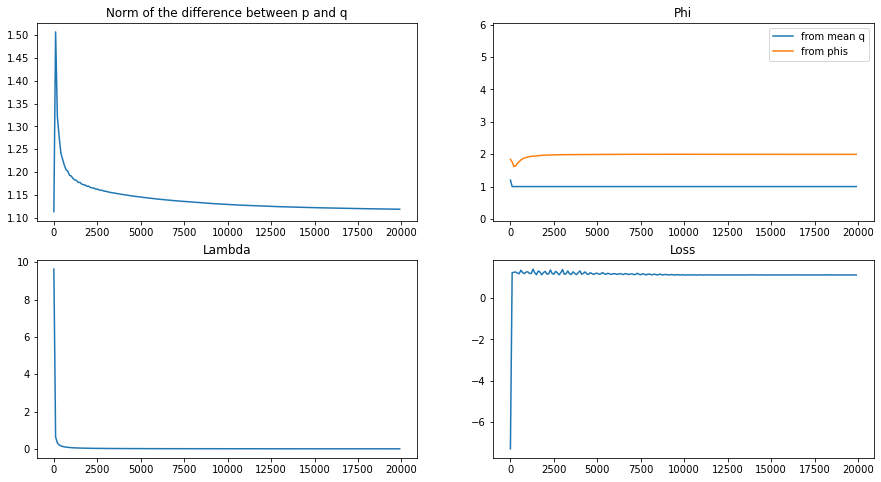

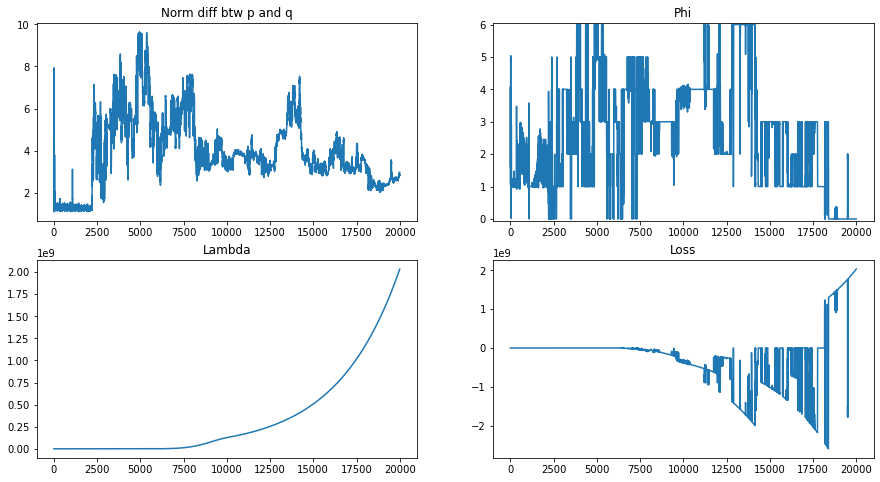


 

Phi freq: {0: 1993, 1: 2878, 2: 2339, 3: 3895, 4: 3290, 5: 892, 6: 1474}

 Found attack distrib q = [[0.         0.73522276 0.54026324 0.46204308]
 [0.26477477 0.         0.43127343 0.79637337]
 [0.45974445 0.53794956 0.         0.6320726 ]
 [0.568728   0.20362224 0.36792725 0.        ]] (erm = tensor([[0., 1., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 0., 0.]])) OR 
q = [[0.         0.88317865 0.91394097 0.8650767 ]
 [0.11682149 0.         0.04190594 0.7840271 ]
 [0.08605417 0.13494529 0.         0.78457636]
 [0.958105   0.21597505 0.21542142 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]]))

 	 EXP THRESHOLD nb 2 = 0.05 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.1895, 0.1832, 0.1994],
        [0.8105, 0.0000, 0.1635, 0.8882],
        [0.8168, 0.8006, 0.0000, 0.1967],
        [0.8365, 0.1118, 0.8033, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.6379, -1.7290, -

EPOCH 2600: 
 	 Q2=tensor([[0.0000, 0.1819, 0.9795, 0.9871],
        [0.8181, 0.0000, 0.0771, 0.2914],
        [0.0205, 0.0129, 0.0000, 0.9729],
        [0.9229, 0.7086, 0.0271, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.7493, 23.3935, 37.7635, -5.4865, -0.7156, 17.4369],
       requires_grad=True) 
 	 grad = tensor([-5., -5., -5., -5., -5.,  5.]) 
 	 lr = 0.3764525000000032 
 	 phi = 0.0 and std_dev = 0.00196078431372549 and norm diff = 3.1552224159240723 
 
 	 lambda_=tensor([20.8145], requires_grad=True) and grad = tensor([1.0000]) 
 	 lr = 0.3764525000000032
EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.9434, 0.7780, 0.9741],
        [0.0566, 0.0000, 0.9792, 0.9638],
        [0.2220, 0.0259, 0.0000, 0.9799],
        [0.0208, 0.0362, 0.0201, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 7.8270,  1.2528, 18.3028, 23.0934, 12.8056, 23.8998],
       requires_grad=True) 
 	 grad = tensor([-5., -5.,  5.,  5.,  5.,  5.]) 
 	 lr = 0.36695250000000335 
 	 phi = 1.0 and std_de

EPOCH 5400: 
 	 Q2=tensor([[0.0000, 0.8449, 0.7226, 0.4706],
        [0.1551, 0.0000, 0.5836, 0.9772],
        [0.2774, 0.5294, 0.0000, 0.9620],
        [0.4164, 0.0228, 0.0380, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.2237,  0.8024, -0.0625,  0.2008, 20.8858, 12.1465],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.24345250000000956 
 	 phi = 2.0 and std_dev = 0.0013607016498184135 and norm diff = 1.1169157028198242 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-1.0000]) 
 	 lr = 0.24345250000000956
EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.8677, 0.7772, 0.4812],
        [0.1323, 0.0000, 0.5623, 0.9768],
        [0.2228, 0.5188, 0.0000, 0.9616],
        [0.4377, 0.0232, 0.0384, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7783,  1.2443, -0.0392,  0.1424, 20.5687, 12.0079],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0., -2., -2.]) 
 	 lr = 0.2339525000000092 
 	 phi = 1.14 and std_de

EPOCH 8200: 
 	 Q2=tensor([[0.0000, 0.8648, 0.7721, 0.7283],
        [0.1352, 0.0000, 0.7711, 0.9771],
        [0.2279, 0.2717, 0.0000, 0.9621],
        [0.2289, 0.0229, 0.0379, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6983,  1.1943,  0.8400,  1.1842, 20.7982, 12.1966],
       requires_grad=True) 
 	 grad = tensor([ 2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.11045249999999864 
 	 phi = 1.0 and std_dev = 0.0011042479306102601 and norm diff = 1.1600675582885742 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-1.0133e-06]) 
 	 lr = 0.11045249999999864
EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.8602, 0.7854, 0.6995],
        [0.1398, 0.0000, 0.7417, 0.9769],
        [0.2146, 0.3005, 0.0000, 0.9619],
        [0.2583, 0.0231, 0.0381, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.5758,  1.3299,  0.6640,  0.9361, 20.6605, 12.1378],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2., -2.]) 
 	 lr = 0.10095249999999892 
 	 phi = 1.0 and st

EPOCH 11000: 
 	 Q2=tensor([[0.0000, 0.8654, 0.7748, 0.4908],
        [0.1346, 0.0000, 0.6321, 0.9770],
        [0.2252, 0.5092, 0.0000, 0.9624],
        [0.3679, 0.0230, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7151e+00,  1.2199e+00, -1.8715e-02,  3.5921e-01,  2.0784e+01,
         1.2282e+01], requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.12 and std_dev = 0.0009534192529917125 and norm diff = 1.1186106204986572 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.1200]) 
 	 lr = 0.024999999999999745
EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.8675, 0.7791, 0.4913],
        [0.1325, 0.0000, 0.6268, 0.9771],
        [0.2209, 0.5087, 0.0000, 0.9623],
        [0.3732, 0.0229, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7748e+00,  1.2631e+00, -1.7704e-02,  3.3979e-01,  2.0840e+01,
         1.2264e+01], requires_grad=True) 
 	 grad = tensor([ 2.,  2., -0., -0.,  2., -2.]

EPOCH 13800: 
 	 Q2=tensor([[0.0000, 0.8653, 0.7723, 0.4847],
        [0.1347, 0.0000, 0.5697, 0.9771],
        [0.2277, 0.5153, 0.0000, 0.9623],
        [0.4303, 0.0229, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7123,  1.1955, -0.0315,  0.1619, 20.7892, 12.2649],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.2 and std_dev = 0.0008512256898069512 and norm diff = 1.1130454540252686 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.2000]) 
 	 lr = 0.024999999999999745
EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.8667, 0.7759, 0.4993],
        [0.1333, 0.0000, 0.5830, 0.9770],
        [0.2241, 0.5007, 0.0000, 0.9625],
        [0.4170, 0.0230, 0.0375, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7501e+00,  1.2314e+00, -1.3355e-03,  1.9896e-01,  2.0785e+01,
         1.2317e+01], requires_grad=True) 
 	 grad = tensor([ 1.8817, -1.9018,  0.1086,  0.0731, -1.9077,  1.8963]) 

EPOCH 16600: 
 	 Q2=tensor([[0.0000, 0.8663, 0.7723, 0.4929],
        [0.1337, 0.0000, 0.5942, 0.9771],
        [0.2277, 0.5071, 0.0000, 0.9624],
        [0.4058, 0.0229, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7401e+00,  1.1960e+00, -1.4502e-02,  2.3204e-01,  2.0788e+01,
         1.2302e+01], requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0.,  2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.12 and std_dev = 0.0007761271487346334 and norm diff = 1.1153028011322021 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.1200]) 
 	 lr = 0.024999999999999745
EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.8648, 0.7761, 0.4920],
        [0.1352, 0.0000, 0.5927, 0.9770],
        [0.2239, 0.5080, 0.0000, 0.9624],
        [0.4073, 0.0230, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6979e+00,  1.2333e+00, -1.6337e-02,  2.2774e-01,  2.0757e+01,
         1.2282e+01], requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0., -2., -2.]

EPOCH 19400: 
 	 Q2=tensor([[0.0000, 0.8661, 0.7733, 0.5086],
        [0.1339, 0.0000, 0.6589, 0.9771],
        [0.2267, 0.4914, 0.0000, 0.9624],
        [0.3411, 0.0229, 0.0376, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.7331e+00, 1.2051e+00, 1.7479e-02, 4.6581e-01, 2.0791e+01, 1.2293e+01],
       requires_grad=True) 
 	 grad = tensor([-2., -2., -0., -0., -2., -2.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.12 and std_dev = 0.0007179396552568181 and norm diff = 1.1165590286254883 
 
 	 lambda_=tensor([0.], requires_grad=True) and grad = tensor([-0.1200]) 
 	 lr = 0.024999999999999745
EPOCH 19600: 
 	 Q2=tensor([[0.0000, 0.8646, 0.7766, 0.5081],
        [0.1354, 0.0000, 0.6529, 0.9771],
        [0.2234, 0.4919, 0.0000, 0.9623],
        [0.3471, 0.0229, 0.0377, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([2.6929e+00, 1.2383e+00, 1.6534e-02, 4.4063e-01, 2.0847e+01, 1.2275e+01],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2., -2.]) 
 	 lr = 0.0

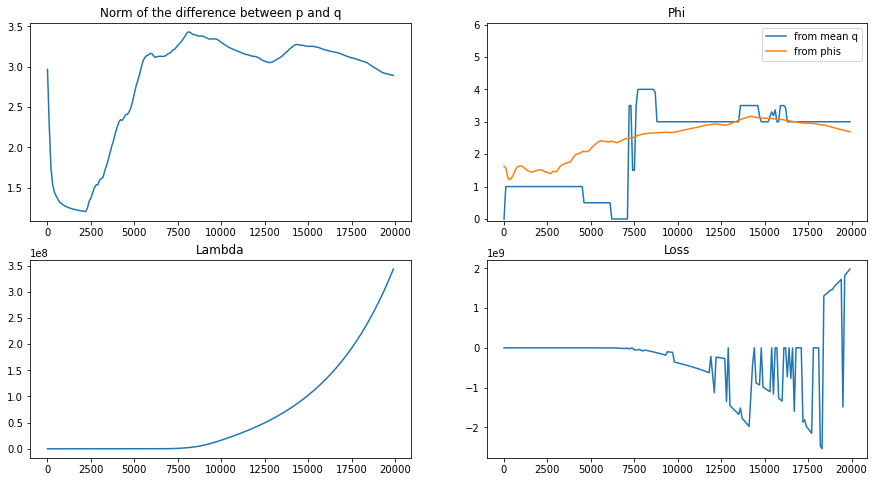

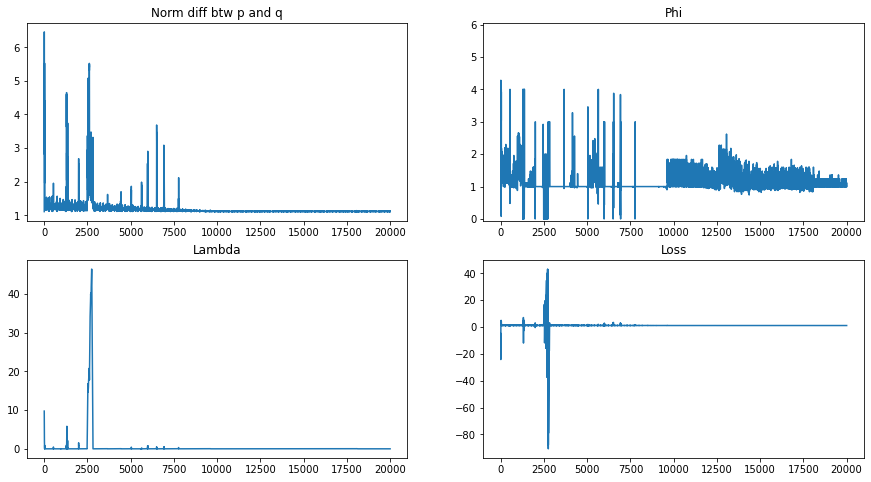


 

Phi freq: {0: 100, 1: 8633, 2: 57, 3: 112, 4: 15, 5: 0, 6: 0}

 Found attack distrib q = [[0.         0.8639951  0.7681726  0.584564  ]
 [0.13600244 0.         0.6631022  0.9720224 ]
 [0.23182403 0.4154408  0.         0.96234167]
 [0.3368999  0.02798068 0.03765943 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])) OR 
q = [[0.         0.8672737  0.77963257 0.5072784 ]
 [0.13275076 0.         0.641431   0.97707516]
 [0.2203691  0.49272117 0.         0.96240246]
 [0.35858122 0.02291457 0.03759457 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]))

 	 EXP THRESHOLD nb 3 = 0.07500000000000001 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.8854, 0.1832, 0.1994],
        [0.1146, 0.0000, 0.1635, 0.8882],
        [0.8168, 0.8006, 0.0000, 0.1967],
        [0.8365, 0.1118, 0.8033, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 3.3621, -1.729

EPOCH 2600: 
 	 Q2=tensor([[0.0000, 0.9659, 0.9776, 0.7268],
        [0.0341, 0.0000, 0.9814, 0.8991],
        [0.0224, 0.2732, 0.0000, 0.9107],
        [0.0186, 0.1009, 0.0893, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([13.6829, 21.3577,  0.8302, 25.9094,  3.9564,  4.6021],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5., -5., -5., -5.]) 
 	 lr = 0.3764525000000032 
 	 phi = 3.5 and std_dev = 0.00196078431372549 and norm diff = 2.3103790283203125 
 
 	 lambda_=tensor([8.0739], requires_grad=True) and grad = tensor([-2.5000]) 
 	 lr = 0.3764525000000032
EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.8562, 0.8048, 0.9540],
        [0.1438, 0.0000, 0.9844, 0.9766],
        [0.1952, 0.0460, 0.0000, 0.9616],
        [0.0156, 0.0234, 0.0384, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.4765,  1.5609,  9.8740, 30.9501, 20.4107, 12.0325],
       requires_grad=True) 
 	 grad = tensor([-1.4912,  0.9554, -0.8296,  4.4884, -2.3492, -1.5569]) 
 	 lr = 0.36695250000000335 

EPOCH 5400: 
 	 Q2=tensor([[0.0000, 0.7406, 0.7345, 0.2402],
        [0.2594, 0.0000, 0.9713, 0.9763],
        [0.2655, 0.7598, 0.0000, 0.9495],
        [0.0287, 0.0237, 0.0505, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 0.9272,  0.8832, -1.0820, 16.4255, 20.0601,  8.8939],
       requires_grad=True) 
 	 grad = tensor([-5.0000,  3.0313, -5.0000,  5.0000,  5.0000,  5.0000]) 
 	 lr = 0.24345250000000956 
 	 phi = 0.5 and std_dev = 0.0013607016498184135 and norm diff = 1.7311242818832397 
 
 	 lambda_=tensor([1.3202], requires_grad=True) and grad = tensor([0.5000]) 
 	 lr = 0.24345250000000956
EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.9538, 0.0665, 0.2292],
        [0.0462, 0.0000, 0.0520, 0.9818],
        [0.9335, 0.7708, 0.0000, 0.9616],
        [0.9480, 0.0182, 0.0384, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 9.8272, -6.5213, -1.1816, -8.6151, 26.4288, 12.0205],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5.,  5.,  5.]) 
 	 lr = 0.233952500000009

EPOCH 8200: 
 	 Q2=tensor([[0.0000, 0.9597, 0.5782, 0.9713],
        [0.0403, 0.0000, 0.9632, 0.9584],
        [0.4218, 0.0287, 0.0000, 0.9482],
        [0.0368, 0.0416, 0.0518, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([11.4063,  0.1854, 16.4036, 12.5707, 11.0101,  8.6599],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.]) 
 	 lr = 0.11045249999999864 
 	 phi = 0.74 and std_dev = 0.0011042479306102601 and norm diff = 1.9723680019378662 
 
 	 lambda_=tensor([0.0130], requires_grad=True) and grad = tensor([0.2600]) 
 	 lr = 0.11045249999999864
EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.9321, 0.9690, 0.8794],
        [0.0679, 0.0000, 0.2404, 0.9699],
        [0.0310, 0.1206, 0.0000, 0.9578],
        [0.7596, 0.0301, 0.0422, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 6.3653, 15.1181,  3.1462, -1.0796, 15.6009, 10.8439],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5., -5.,  5.]) 
 	 lr = 0.10095249999999892 
 	 phi = 0.5 and st

EPOCH 11000: 
 	 Q2=tensor([[0.0000, 0.8636, 0.7838, 0.4724],
        [0.1364, 0.0000, 0.7176, 0.9765],
        [0.2162, 0.5276, 0.0000, 0.9630],
        [0.2824, 0.0235, 0.0370, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6664,  1.3129, -0.0585,  0.7702, 20.2811, 12.4981],
       requires_grad=True) 
 	 grad = tensor([4.4360, 5.0000, 3.5369, 1.1901, 0.0618, 1.7197]) 
 	 lr = 0.024999999999999745 
 	 phi = 0.98 and std_dev = 0.0009534192529917125 and norm diff = 1.137608289718628 
 
 	 lambda_=tensor([0.4557], requires_grad=True) and grad = tensor([0.0200]) 
 	 lr = 0.024999999999999745
EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.8184, 0.9048, 0.2854],
        [0.1816, 0.0000, 0.9074, 0.9760],
        [0.0952, 0.7146, 0.0000, 0.9650],
        [0.0926, 0.0240, 0.0350, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.7532,  4.2513, -0.7519,  4.4000, 19.8302, 13.2857],
       requires_grad=True) 
 	 grad = tensor([-0.1542,  5.0000,  5.0000, -5.0000,  5.0000, -5.0000]) 
 	 

EPOCH 13800: 
 	 Q2=tensor([[0.0000, 0.8595, 0.8813, 0.9172],
        [0.1405, 0.0000, 0.7862, 0.9634],
        [0.1187, 0.0828, 0.0000, 0.9420],
        [0.2138, 0.0366, 0.0580, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.5593,  3.2116,  5.0351,  1.3391, 12.6635,  7.6221],
       requires_grad=True) 
 	 grad = tensor([-5., -5.,  5., -5.,  5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 0.5 and std_dev = 0.0008512256898069512 and norm diff = 1.4019653797149658 
 
 	 lambda_=tensor([29.3148], requires_grad=True) and grad = tensor([0.5000]) 
 	 lr = 0.024999999999999745
EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.2223, 0.8843, 0.9042],
        [0.7777, 0.0000, 0.7243, 0.9590],
        [0.1157, 0.0958, 0.0000, 0.9400],
        [0.2757, 0.0410, 0.0600, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.2495,  3.3200,  4.2218,  0.8138, 11.1831,  7.3328],
       requires_grad=True) 
 	 grad = tensor([-5.,  5.,  5.,  5.,  5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.5 a

EPOCH 16600: 
 	 Q2=tensor([[0.0000, 0.8725, 0.8502, 0.7346],
        [0.1275, 0.0000, 0.9113, 0.9619],
        [0.1498, 0.2654, 0.0000, 0.9536],
        [0.0887, 0.0381, 0.0464, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.9218,  2.3384,  0.8840,  4.6358, 12.1161,  9.7718],
       requires_grad=True) 
 	 grad = tensor([ 5.,  5.,  5.,  5., -5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 0.5 and std_dev = 0.0007761271487346334 and norm diff = 1.3013582229614258 
 
 	 lambda_=tensor([5.6796], requires_grad=True) and grad = tensor([0.5000]) 
 	 lr = 0.024999999999999745
EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.8764, 0.7761, 0.7219],
        [0.1236, 0.0000, 0.9129, 0.9688],
        [0.2239, 0.2781, 0.0000, 0.9618],
        [0.0871, 0.0312, 0.0382, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 3.0456,  1.2336,  0.7979,  4.7389, 15.0013, 12.0765],
       requires_grad=True) 
 	 grad = tensor([ 5.0000,  5.0000, -1.3331, -1.9682, -2.9566, -5.0000]) 
 	 lr = 0.02499999999

EPOCH 19400: 
 	 Q2=tensor([[0.0000, 0.1746, 0.1275, 0.9431],
        [0.8254, 0.0000, 0.9309, 0.9623],
        [0.8725, 0.0569, 0.0000, 0.9452],
        [0.0691, 0.0377, 0.0548, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.8635, -2.9212,  7.7894,  6.2320, 12.2494,  8.1159],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5.,  5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 2.5 and std_dev = 0.0007179396552568181 and norm diff = 3.8579840660095215 
 
 	 lambda_=tensor([2.4933], requires_grad=True) and grad = tensor([-1.5000]) 
 	 lr = 0.024999999999999745
EPOCH 19600: 
 	 Q2=tensor([[0.0000, 0.8640, 0.7212, 0.9305],
        [0.1360, 0.0000, 0.9325, 0.9697],
        [0.2788, 0.0695, 0.0000, 0.9633],
        [0.0675, 0.0303, 0.0367, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.6770,  0.7934,  6.1916,  6.4048, 15.4797, 12.6222],
       requires_grad=True) 
 	 grad = tensor([ 5.0000, -5.0000, -5.0000, -5.0000,  5.0000, -0.0141]) 
 	 lr = 0.0249999999

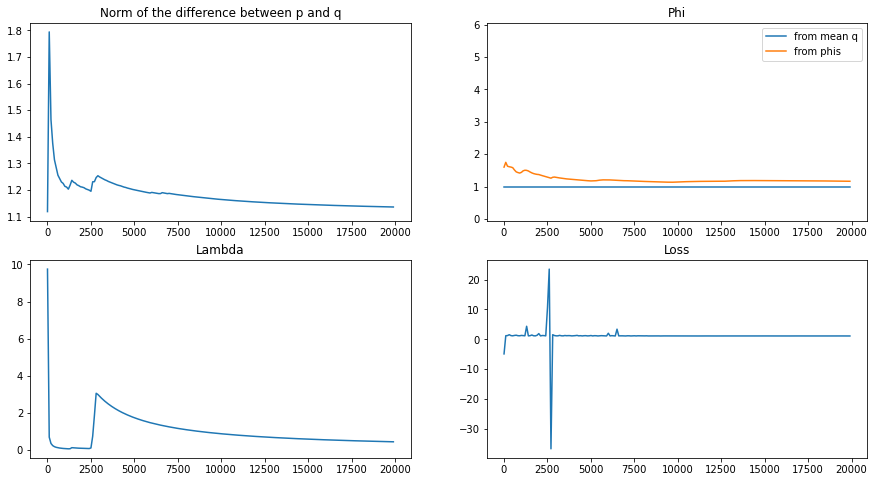

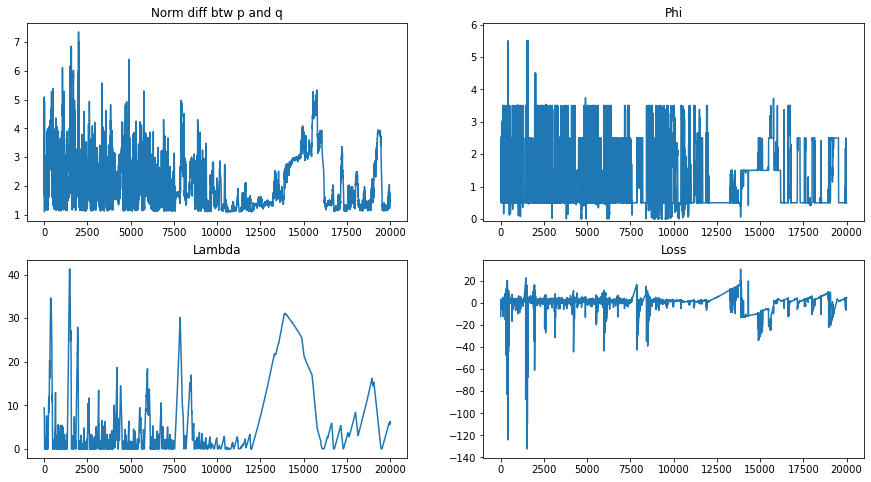


 

Phi freq: {0: 49, 1: 51, 2: 29, 3: 10, 4: 0, 5: 0, 6: 0}

 Found attack distrib q = [[0.         0.71070516 0.7113688  0.79530615]
 [0.28929412 0.         0.79960185 0.9478926 ]
 [0.28862455 0.20469    0.         0.9253472 ]
 [0.20040382 0.05210954 0.07465184 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])) OR 
q = [[0.         0.8785684  0.53715575 0.9144202 ]
 [0.12141795 0.         0.8999029  0.9669265 ]
 [0.46284327 0.08560147 0.         0.9537664 ]
 [0.10009285 0.03305799 0.04621385 0.        ]] (erm = tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]))

 	 EXP THRESHOLD nb 4 = 0.1 
 
 

EPOCH 0: 
 	 Q2=tensor([[0.0000, 0.1895, 0.1832, 0.1994],
        [0.8105, 0.0000, 0.1635, 0.8882],
        [0.8168, 0.8006, 0.0000, 0.8878],
        [0.8365, 0.1118, 0.1122, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.6379, -1.7290, -1.5070, -2.0581, 

EPOCH 2600: 
 	 Q2=tensor([[0.0000, 0.9107, 0.4473, 0.9598],
        [0.0893, 0.0000, 0.9839, 0.9768],
        [0.5527, 0.0402, 0.0000, 0.9691],
        [0.0161, 0.0232, 0.0309, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 4.5975, -0.1178, 11.4342, 30.0802, 20.5314, 15.1615],
       requires_grad=True) 
 	 grad = tensor([ 5.0000, -1.0425,  5.0000,  5.0000,  2.0687,  1.5192]) 
 	 lr = 0.3764525000000032 
 	 phi = 0.5 and std_dev = 0.00196078431372549 and norm diff = 1.3954181671142578 
 
 	 lambda_=tensor([0.7545], requires_grad=True) and grad = tensor([0.5000]) 
 	 lr = 0.3764525000000032
EPOCH 2800: 
 	 Q2=tensor([[0.0000, 0.7963, 0.9103, 0.9690],
        [0.2037, 0.0000, 0.9872, 0.9773],
        [0.0897, 0.0310, 0.0000, 0.9580],
        [0.0128, 0.0227, 0.0420, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.4552,  4.5743, 15.1070, 38.1153, 21.0013, 10.9180],
       requires_grad=True) 
 	 grad = tensor([-3.4456e-01, -1.8956e+00, -2.9105e+00,  1.3880e-03,  1.0662e+

EPOCH 5400: 
 	 Q2=tensor([[0.0000, 0.5144, 0.8883, 0.9165],
        [0.4856, 0.0000, 0.7930, 0.9747],
        [0.1117, 0.0835, 0.0000, 0.9609],
        [0.2070, 0.0253, 0.0391, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 0.0297,  3.4744,  4.9849,  1.4159, 18.7494, 11.7818],
       requires_grad=True) 
 	 grad = tensor([ 5.,  5.,  5., -5., -5., -5.]) 
 	 lr = 0.24345250000000956 
 	 phi = 1.5 and std_dev = 0.0013607016498184135 and norm diff = 2.5145716667175293 
 
 	 lambda_=tensor([3.3578], requires_grad=True) and grad = tensor([-0.5000]) 
 	 lr = 0.24345250000000956
EPOCH 5600: 
 	 Q2=tensor([[0.0000, 0.8659, 0.6498, 0.9526],
        [0.1341, 0.0000, 0.9761, 0.9771],
        [0.3502, 0.0474, 0.0000, 0.9626],
        [0.0239, 0.0229, 0.0374, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 2.7288,  0.4278,  9.5404, 19.8855, 20.8003, 12.3673],
       requires_grad=True) 
 	 grad = tensor([-2.,  2., -0., -0.,  2.,  2.]) 
 	 lr = 0.2339525000000092 
 	 phi = 0.66 and st

EPOCH 8200: 
 	 Q2=tensor([[0.0000, 0.8042, 0.8489, 0.9507],
        [0.1958, 0.0000, 0.9634, 0.9765],
        [0.1511, 0.0493, 0.0000, 0.9654],
        [0.0366, 0.0235, 0.0346, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.5541,  2.3100,  9.1332, 12.6781, 20.3206, 13.4417],
       requires_grad=True) 
 	 grad = tensor([-0.3315,  5.0000, -0.4004, -4.5402,  4.3235, -0.6389]) 
 	 lr = 0.11045249999999864 
 	 phi = 0.5 and std_dev = 0.0011042479306102601 and norm diff = 1.320184588432312 
 
 	 lambda_=tensor([0.5225], requires_grad=True) and grad = tensor([0.5000]) 
 	 lr = 0.11045249999999864
EPOCH 8400: 
 	 Q2=tensor([[0.0000, 0.6243, 0.3476, 0.7465],
        [0.3757, 0.0000, 0.9640, 0.9761],
        [0.6524, 0.2535, 0.0000, 0.9692],
        [0.0360, 0.0239, 0.0308, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 0.3308, -0.4384,  0.9721, 12.8883, 19.8794, 15.2478],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5.,  5.,  5.]) 
 	 lr = 0.1009524999999989

EPOCH 11000: 
 	 Q2=tensor([[0.0000, 0.9093, 0.2857, 0.9389],
        [0.0907, 0.0000, 0.9252, 0.9696],
        [0.7143, 0.0611, 0.0000, 0.7948],
        [0.0748, 0.0304, 0.2052, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 4.5104, -0.7504,  7.1790,  5.6804, 15.4306,  1.4367],
       requires_grad=True) 
 	 grad = tensor([-5., -5., -5., -5.,  5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 2.5 and std_dev = 0.0009534192529917125 and norm diff = 2.4652559757232666 
 
 	 lambda_=tensor([16.8544], requires_grad=True) and grad = tensor([-1.5000]) 
 	 lr = 0.024999999999999745
EPOCH 11200: 
 	 Q2=tensor([[0.0000, 0.9506, 0.2863, 0.9398],
        [0.0494, 0.0000, 0.8314, 0.9626],
        [0.7137, 0.0602, 0.0000, 0.8952],
        [0.1686, 0.0374, 0.1048, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 9.1126, -0.7462,  7.3074,  1.9664, 12.3556,  3.7724],
       requires_grad=True) 
 	 grad = tensor([ 5.,  5.,  5., -5., -5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 2.5 

EPOCH 13800: 
 	 Q2=tensor([[0.0000, 0.8988, 0.1255, 0.9449],
        [0.1012, 0.0000, 0.8748, 0.9689],
        [0.8745, 0.0551, 0.0000, 0.9379],
        [0.1252, 0.0311, 0.0621, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 3.9403, -2.9843,  8.0705,  2.9926, 15.0825,  7.0579],
       requires_grad=True) 
 	 grad = tensor([ 5.0000, -2.2737, -5.0000, -5.0000,  5.0000,  5.0000]) 
 	 lr = 0.024999999999999745 
 	 phi = 2.5 and std_dev = 0.0008512256898069512 and norm diff = 2.528264045715332 
 
 	 lambda_=tensor([20.6242], requires_grad=True) and grad = tensor([-1.5000]) 
 	 lr = 0.024999999999999745
EPOCH 14000: 
 	 Q2=tensor([[0.0000, 0.9061, 0.1677, 0.9453],
        [0.0939, 0.0000, 0.3042, 0.9611],
        [0.8323, 0.0547, 0.0000, 0.9272],
        [0.6958, 0.0389, 0.0728, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 4.3239, -1.9806,  8.1487, -0.6435, 11.8596,  5.8722],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5.,  5., -5.,  5.]) 
 	 lr = 0.0249999999

EPOCH 16600: 
 	 Q2=tensor([[0.0000, 0.2067, 0.8869, 0.8968],
        [0.7933, 0.0000, 0.7664, 0.9690],
        [0.1131, 0.1032, 0.0000, 0.8885],
        [0.2336, 0.0310, 0.1115, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([-1.4191,  3.4190,  3.8446,  1.1402, 15.1509,  3.4833],
       requires_grad=True) 
 	 grad = tensor([ 5., -5.,  5.,  5.,  5.,  5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 1.5 and std_dev = 0.0007761271487346334 and norm diff = 2.8482277393341064 
 
 	 lambda_=tensor([10.5666], requires_grad=True) and grad = tensor([-0.5000]) 
 	 lr = 0.024999999999999745
EPOCH 16800: 
 	 Q2=tensor([[0.0000, 0.8227, 0.8897, 0.3302],
        [0.1773, 0.0000, 0.3311, 0.9648],
        [0.1103, 0.6698, 0.0000, 0.9066],
        [0.6689, 0.0352, 0.0934, 0.0000]], grad_fn=<IndexPutBackward0>) 
 	 S_=tensor([ 1.8203,  3.5324, -0.5143, -0.5100, 13.2120,  4.3561],
       requires_grad=True) 
 	 grad = tensor([ 5., -5., -5.,  5., -5., -5.]) 
 	 lr = 0.024999999999999745 
 	 phi = 3.5 


KeyboardInterrupt



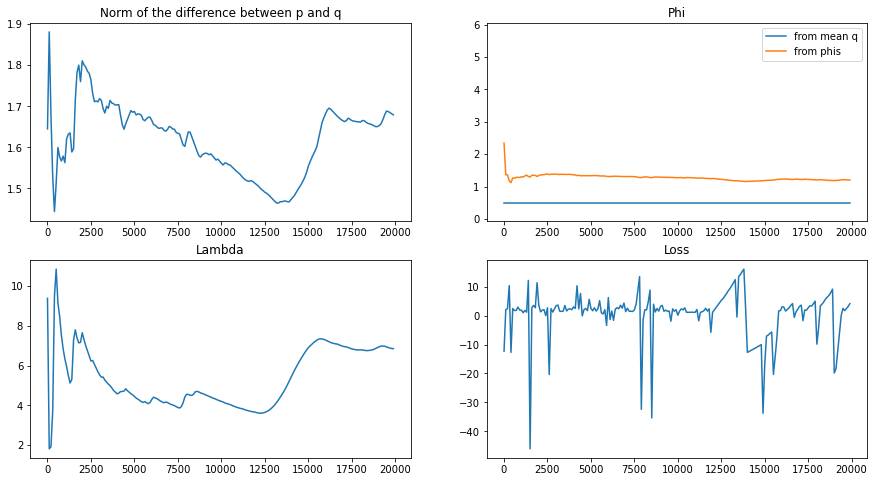

In [79]:
# Maxpair
dist = "maxpair"
perf_list_maxpair, eps_list_maxpair1, eps_list_maxpair2, alt_eps_list_maxpair1, alt_eps_list_maxpair2, dict_res_training_maxpair = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_maxpair} \n\n and eps_list1 (l1 norm) = {eps_list_maxpair1}  \n and eps_list2 (l2 norm) = {eps_list_maxpair2} \n\n and alt eps list1 (l1 norm) = {alt_eps_list_maxpair1} \n and alt eps list2 (l2 norm) = {alt_eps_list_maxpair2}")

plt.plot(perf_list_maxpair, eps_list_maxpair1, '*')
plt.plot(perf_list_maxpair, eps_list_maxpair2, '*')
plt.plot(perf_list_maxpair, alt_eps_list_maxpair1, 'o')
plt.plot(perf_list_maxpair, alt_eps_list_maxpair2, 'o')
plt.show()

### Merge

In [ ]:
# Merge
dist = "merge"
perf_list_merge, eps_list_merge1, eps_list_merge2, alt_eps_list_merge1, alt_eps_list_merge2, dict_res_training_merge = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_merge} and eps_list1 (l1 norm) = {eps_list_merge1} and eps_list2 (l2 norm) = {eps_list_merge2}")

plt.plot(perf_list_merge, eps_list_merge1, '*')
plt.plot(perf_list_merge, eps_list_merge2, '*')
plt.show()

### Depth

In [ ]:
# Depth
dist = "depth"
perf_list_depth, eps_list_depth1, eps_list_depth2, alt_eps_list_depth1, alt_eps_list_depth2, dict_res_training_depth = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_depth} and eps_list1 (l1 norm) = {eps_list_depth1} and eps_list2 (l2 norm) = {eps_list_depth2}")

plt.plot(perf_list_depth, eps_list_depth1, '*')
plt.plot(perf_list_depth, eps_list_depth2, '*')
plt.show()

### Wasserstein

In [ ]:
# Wasserstein
dist = "wasserstein"
perf_list_wasserstein, eps_list_wasserstein1, eps_list_wasserstein2, alt_eps_list_wasserstein1, alt_eps_list_wasserstein2, dict_res_training_wasserstein = launch_exp(dist, p_torch w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_wasserstein} and eps_list1 (l1 norm) = {eps_list_wasserstein1} and eps_list2 (l2 norm) = {eps_list_wasserstein2}")

plt.plot(perf_list_wasserstein, eps_list_wasserstein1, '*')
plt.plot(perf_list_wasserstein, eps_list_wasserstein2, '*')
plt.show()

# Load Old Experiments

In [ ]:
# Generate a distribution
m = 0.25
w = np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-2)**m, np.exp(n_items-3)**m])
print(w)
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)
print(p_torch)

# Other parameters
delta = 1
epochs = 10000
thresholds_ = np.linspace(0., 0.5, 11) #get_automatic_thresholds(w)
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
nb_simu_training = 25

In [ ]:
def get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, folder_path=None):
    if folder_path == None:
        folder_path = f"{os.getcwd()}/perf_robustness_profile/"
    filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}_ratio_{ratio_norm_}.pt"
    return folder_path+filename

def load_plot_exp(path, dist, plot_training=False):
    dict_res = torch.load(mypath)
    training_dict = dict_res['training_dict']
    final_val_dict = dict_res['final_val_dict']
    
    # Check if there are several thresholds
    if 'threshold' in list(training_dict.keys())[0]:
        perf_list_all = list()
        eps_list1_all = list()
        eps_list2_all = list()
        alt_eps_list1_all = list()
        alt_eps_list2_all = list()
        thresholds = [float(a_.split('_')[1]) for a_ in list(training_dict.keys())]
        for (threshold, key) in zip(thresholds, list(training_dict.keys())):
            dist_Tp_Tq = lambda _P,_Q: torch_dist(dist, _P, _Q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            if plot_training:
                plot_end_training(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=training_dict[key]['norms'], losses=training_dict[key]['losses'], mean_qs_=training_dict[key]['mean_qs'], phis_=training_dict[key]['phis'], mean_phi2_=training_dict[key]['mean_phi2'], lambdas_=training_dict[key]['lambdas'], mean_lambdas_=training_dict[key]['mean_lambdas'], grad_data=training_dict[key]['grad_data'], freq_phi_=training_dict[key]['freq_phi'], norm_type=norm_type)
            perf_list = final_val_dict[key]['perf_list']
            eps_list1 = final_val_dict[key]['eps_list1']
            eps_list2 = final_val_dict[key]['eps_list2']
            alt_eps_list1 = final_val_dict[key]['alt_eps_list1']
            alt_eps_list2 = final_val_dict[key]['alt_eps_list2']
            
            print(f"perf_list = {perf_list} \n and eps_list1 (l1 norm) = {eps_list1}  \n and eps_list2 (l2 norm) = {eps_list2}")

            plt.plot(perf_list, eps_list1, '*')
            plt.plot(perf_list, eps_list2, '*')
            plt.plot(perf_list, alt_eps_list1, 'o')
            plt.plot(perf_list, alt_eps_list2, 'o')
            plt.show()
            
            perf_list_all.append(perf_list)
            eps_list1_all.append(eps_list1)
            eps_list2_all.append(eps_list2)
            alt_eps_list1_all.append(alt_eps_list1)
            alt_eps_list2_all.append(alt_eps_list2)
        return perf_list_all, eps_list1_all, eps_list2_all, alt_eps_list1, alt_eps_list2, thresholds
    else:
        dist_Tp_Tq = lambda _P,_Q: torch_dist(dist, _P, _Q, torch_all_ranks, threshold=0, dist_type_sym=dist_type_sym)
        if plot_training:
            plot_end_training(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=training_dict['norms'], losses=training_dict['losses'], mean_qs_=training_dict['mean_qs'], phis_=training_dict['phis'], mean_phi2_=training_dict['mean_phi2'], lambdas_=training_dict['lambdas'], mean_lambdas_=training_dict['mean_lambdas'], grad_data=training_dict['grad_data'], freq_phi_=training_dict['freq_phi'], norm_type=norm_type)
        perf_list = final_val_dict['perf_list']
        eps_list1 = final_val_dict['eps_list1']
        eps_list2 = final_val_dict['eps_list2']
        alt_eps_list1 = final_val_dict['alt_eps_list1']
        alt_eps_list2 = final_val_dict['alt_eps_list2']

        print(f"perf_list = {perf_list} \n and eps_list1 (l1 norm) = {eps_list1}  \n and eps_list2 (l2 norm) = {eps_list2}")

        plt.plot(perf_list, eps_list1, '*')
        plt.plot(perf_list, eps_list2, '*')
        plt.plot(perf_list, alt_eps_list1, 'o')
        plt.plot(perf_list, alt_eps_list2, 'o')
        plt.show()
        return perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, [0]
        
    
    

In [ ]:
dist = "erm"
mypath = get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_)
#dict_res_erm = torch.load(mypath)
perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, thresholds = load_plot_exp(mypath, dist)
print(f"perf = {perf_list} \n l1 norm diff = {eps_list1} \n l2 norm diff = {eps_list2} \n\n l1 norm diff = {alt_eps_list1} \n l2 norm diff = {alt_eps_list2} ")

In [ ]:
dist = "maxpair"
mypath = get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_)
#dict_res_erm = torch.load(mypath)
perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, thresholds = load_plot_exp(mypath, dist)
print(f"perf = {perf_list} \n l1 norm diff = {eps_list1} \n l2 norm diff = {eps_list2} \n\n l1 norm diff = {alt_eps_list1} \n l2 norm diff = {alt_eps_list2} ")

In [ ]:
eps_list1

# Plot all results

In [ ]:
plt.plot(perf_list_erm, alt_eps_list_erm2, 'x', label="ERM")
#plt.plot(perf_list_merge, eps_list_merge2, 'o', label="Merge")
plt.plot(perf_list_maxpair, alt_eps_list_maxpair2, '*', label="Maxpair")
#plt.plot(perf_list_depth, eps_list_depth2, 's', label="Depth")
plt.xlabel("Performance (loss)")
plt.ylabel("Robustness (bkdwn pts)")
#plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()